# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns, astropy.units as u

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats, optimize

from code.xrt import XRT_lightcurve, get_photonIndex, get_temporalIndex, get_columnDensity
from code.uncertainty import AsymmetricUncertainty, UncertaintyArray

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")
log_mean = lambda x1,x2 : 10**np.mean((np.log10(x1),np.log10(x2)))

Main code has been moved to [`pipeline.ipynb`](./pipeline.ipynb). Running the cell below will perform the entire analysis and output the list of dark sGRBs.

In [51]:
error_B_ox = False # whether to incorporate Δβₒₓ (due to temporal separation) in errors
restrictive = True # whether to use a restrictive inequality cut for determining darkness (<< vs. <)
max_dt = 0.2 # maximum allowable temporal separation between optical and X-ray data points (%)

%run pipeline.ipynb

Finished xray.
Finished optical.
Using B_ox
210323A	 3
200411A	 1
200219A	 2
191031D	 1
190719C	 6
181123B	 1
180727A	 1
180618A	 1
180204A	 2
170827A	 2
170822A	 7
170728B	 31
170127B	 1
161004A	 2
161001A	 1
160927A	 1
160821B	 4
160624A	 2
160525B	 1
160408A	 1
151229A	 6
150831A	 1
150424A	 8
150120A	 1
140930B	 1
131004A	 1
130912A	 6
130603B	 4
121226A	 1
120804A	 4
120521A	 1
120305A	 2
111117A	 1
110402A	 1
110112A	 1
110106A	 1
101219A	 2
100816A	 1
100702A	 1
100625A	 2
100117A	 1
090515	 1
090510	 9
090423	 6
081024A	 1
080913	 8
080503	 2
080123	 2
070714B	 3
070707	 2
060313	 5
060121	 39


In [78]:
dark_GRBs

,GRB,dark points w/ Δβₒₓ,dark points no Δβₒₓ
0,210323A,1,3
1,200411A,1,1
2,200219A,1,2
3,191031D,1,1
4,190719C,6,6
5,181123B,1,1
6,180727A,1,1
7,180618A,1,1
8,180204A,2,2
9,170827A,2,2


## $\LaTeX$ table formatting

In [ ]:
def round_scientific(number, places):
    return float(f"%.{places}e"%number)

sample_df = sGRBs[['GRB', 'TriggerNumber', 'BAT T90[sec]', 'Redshift', 'Beta_X', 'Beta_X_neg', 'Beta_X_pos', 'N_H (intrinsic)']].copy()
sample_df.loc[sample_df["Beta_X"].notna(),"B_x"] = [AsymmetricUncertainty(*row[['Beta_X', 'Beta_X_pos', 'Beta_X_neg']]) for i,row in sample_df.loc[sample_df["Beta_X"].notna(),:].iterrows()]
sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"] = [AsymmetricUncertainty(entry) for entry in sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"]]
sample_df.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'], axis=1, inplace=True)
sample_df.rename(columns={"B_x":"Beta_X","BAT T90[sec]":"T90","TriggerNumber":"Trigger"},inplace=True)

for i,row in sample_df.iterrows():
    bx = row["Beta_X"]
    nh = row["N_H (intrinsic)"]
    if pd.notna(nh):
#         rounded_nh = (round_scientific(number,3) for number in nh.items())
#         rounded_nh = AsymmetricUncertainty(*rounded_nh)
        sample_df.loc[i,"N_H (intrinsic)"] = AsymmetricUncertainty(round(nh.value/1e21,3),
                                                                   round(nh.plus/1e21,3),
                                                                   round(nh.minus/1e21,3))
    if pd.notna(bx):
        rounded_bx = (round(number,2) for number in bx.items())
        rounded_bx = AsymmetricUncertainty(*rounded_bx)
        sample_df.loc[i,"Beta_X"] = rounded_bx
table_str = sample_df.to_latex(index=False, columns=["GRB","Trigger","T90","Redshift","Beta_X","N_H (intrinsic)"],na_rep='---')

In [ ]:
for line in table_str.split("\n")[4:-3]:
    grb,trig,t90,z,beta_orig,n_h_orig = line.split("&")
    n_h_orig = n_h_orig[:-2]
    if beta_orig.strip() != "---":
        beta = beta_orig
        beta = beta.replace(" (+","^{+")
        beta = beta.replace(", -","}_{-")
        beta = beta.replace(")","}")
        beta = beta.replace("±",r"\pm")
        table_str = table_str.replace(beta_orig," $"+beta.strip()+"$ ")
    if n_h_orig.strip() != "---":
        n_h = n_h_orig
        n_h = n_h.replace("(+","^{+")
        n_h = n_h.replace(", -","}_{-")
        n_h = n_h.replace(")","}")
        if "±" not in n_h:
            pass
#             print(n_h)
#             val,err = n_h.split()
#             n_h = "("+val+")"+err
        else:
            n_h = n_h.replace("±",r"\pm")
        table_str = table_str.replace(n_h_orig," $"+n_h.strip()+"$ ")
# table_str = table_str.replace("e+19",r"\times10^{19}")
# table_str = table_str.replace("e+20",r"\times10^{20}")
# table_str = table_str.replace("e+21",r"\times10^{21}")
# table_str = table_str.replace("e+22",r"\times10^{22}")
print(table_str)

In [111]:
print(pd.DataFrame(np.array([[grb,sum(all_optical["GRB"]==grb),sum(xrt_data["GRB"]==grb),sum(results["GRB"]==grb),sum(close_times["GRB"]==grb)] for grb in sGRBs["GRB"]]),
             columns=["GRB","Optical points","X-ray points","Temporal matches","Dark points"]).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
     GRB & Optical points & X-ray points & Temporal matches & Dark points \\
\midrule
 210413B &              4 &            0 &                0 &           0 \\
 210410A &             16 &           66 &               14 &           0 \\
 210323A &             18 &           30 &               30 &           4 \\
 210119A &              6 &            0 &                0 &           0 \\
 201221D &             20 &            2 &                0 &           0 \\
 201214B &             16 &            0 &                0 &           0 \\
 201006A &             17 &            6 &                5 &           0 \\
 200907B &              9 &            8 &                4 &           0 \\
 200826A &              4 &            7 &                1 &           0 \\
 200716C &             15 &          363 &                3 &           0 \\
 200623A &              1 &            0 &                0 &           0 \\
 200522A &             24 &        

## *Swift*-XRT lightcurve/spectrum demo

In [5]:
burst = "051221A"
fluxdata = XRT_lightcurve(burst,sGRBs)
Gamma,mode = get_photonIndex(burst,sGRBs)
NH,mode = get_columnDensity(burst,sGRBs)

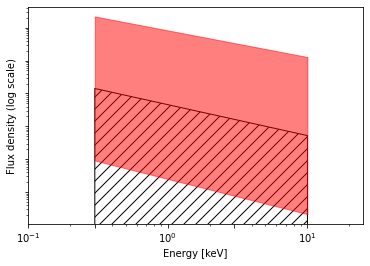

In [6]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

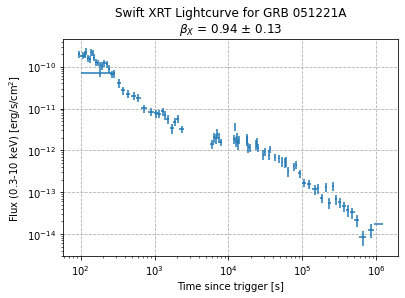

In [13]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,
             yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X$ = %s" % (burst,Gamma-1))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

## Filter transmission calculations

c:\users\caden gobat\appdata\local\programs\python\python38\lib\site-packages\pandas\io\parsers.py:765: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


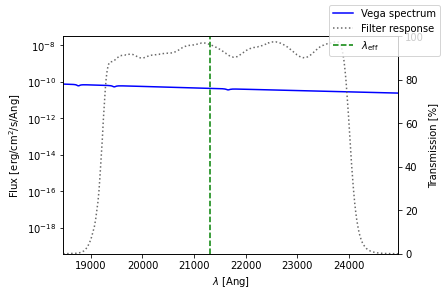

21303.690943444715

In [4]:
from code.fluxtools import effective_wavelength

# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt",header=None)
# I_filter.columns = ["Wavelength","Transmission"]
# I_filter["Wavelength"] *= 10
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_J["Wavelength"] *= 10000
MOSFIRE_J["Transmission"] *= 100

MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ",engine='python').iloc[:,:2]
MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_K["Wavelength"] *= 10000
MOSFIRE_K["Transmission"] *= 100

# REMIR_H = pd.read_csv("./data/REM/H.csv",header=None,names=["Wavelength","Transmission"])
# REMIR_H.sort_values(by="Wavelength",inplace=True)
# REMIR_H["Wavelength"] *= 10
# REMIR_r = pd.read_csv("./data/REM/r'.csv")
# REMIR_r.sort_values(by="Wavelength",inplace=True)
# REMIR_r["Wavelength"] *= 10

# LDSS3_i = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/i01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/r01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r["Wavelength"] *= 10 # nm to Ang

# IMACS_r_below = pd.read_csv("./data/Magellan/IMACS_r.csv",header=None)
# IMACS_r_below.columns = ["Wavelength","Transmission"]
# IMACS_r_below = IMACS_r_below[IMACS_r_below["Wavelength"]<600].copy()
# IMACS_r_below.sort_values(by="Wavelength",inplace=True)
# IMACS_r_below.drop_duplicates(subset=["Wavelength"],inplace=True)
# IMACS_r_above = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/imacs/imacs-filters/sloan_r_red01.txt",
#                               delimiter="\t",names=["Wavelength","Transmission"])
# IMACS_r = IMACS_r_below.append(IMACS_r_above,ignore_index=True)
# IMACS_r["Wavelength"] *= 10

effective_wavelength(MOSFIRE_K,show_plot=True)

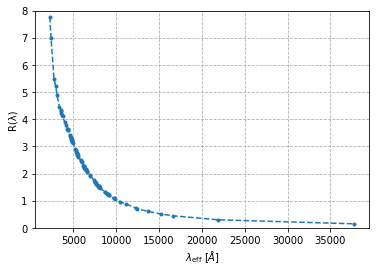

In [72]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"],fill_value="extrapolate") # function that takes a wavelength [Ang] and returns the corresponding R_b value

RbTable.drop([37,55,61,73],axis=0,inplace=True) # smoothing
RbTable.sort_values(by="lambda_eff",inplace=True) # sort in order of wavelength: UV -> IR
plt.plot(RbTable["lambda_eff"], RbTable["R_b"], ".--")
plt.xlabel("$\lambda_\mathrm{eff}$ [$\AA$]")
plt.ylabel("R(λ)")
plt.ylim(0,8)
plt.grid(linestyle="--")
# plt.savefig("./products/RbTable.png",bbox_inches="tight",dpi=300,)

## Plot dark GRBs' lightcurves

1 0 0


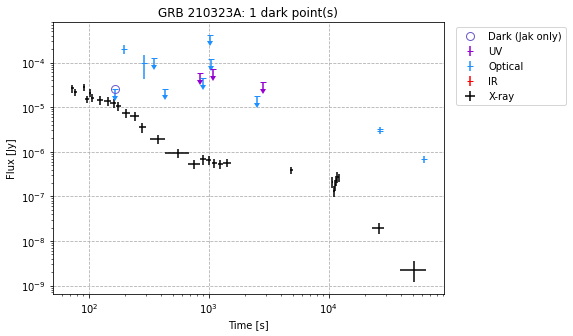

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
15,210323A,164.0,0.022176,"0.11224670473253857 (+0.04278139383706613, -inf)",0.7 ± 0.2,1.6,True,False


1 0 0


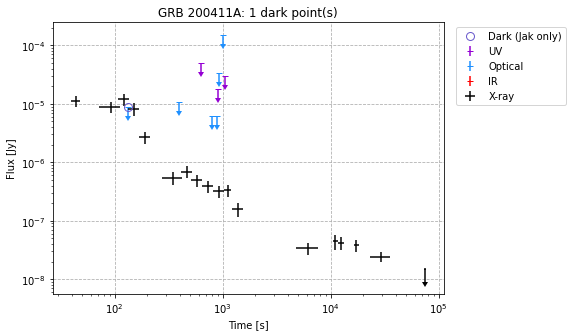

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
67,200411A,133.0,0.102198,"-0.04851978052332558 (+0.05688337699006908, -inf)","0.6799999999999999 (+0.23, -0.22)",1.02,True,False


0 0 1


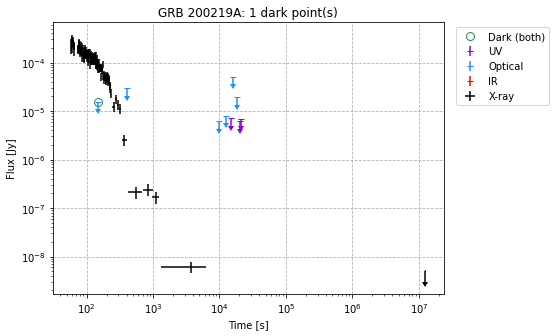

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
99,200219A,150.0,0.00487,"-0.2738795394973301 (+0.04551266355059989, -inf)","0.96 (+0.35, -0.25)",2.05,True,True


1 0 0


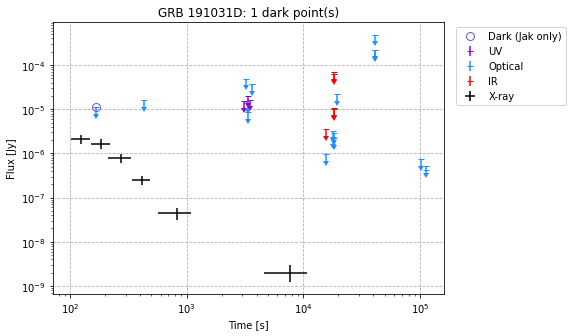

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
117,191031D,167.5,0.099559,"0.3013995792493801 (+0.09686586908982647, -inf)","0.93 (+0.28, -0.17)",1.95,True,False


5 0 1


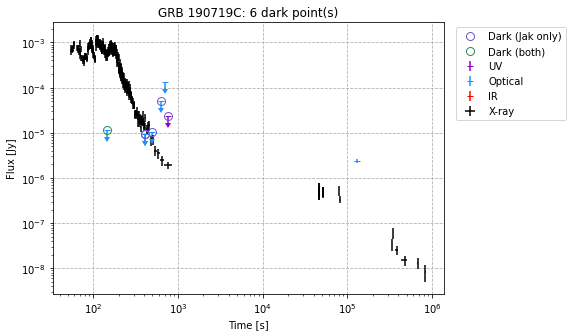

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
144,190719C,146.0,0.000404,"-0.5889694249784356 (+0.0811811972024807, -inf)","0.6299999999999999 (+0.3, -0.28)",1.0,True,True
227,190719C,413.5,0.000571,"-0.12907305411767914 (+0.03672237773612864, -inf)","0.6299999999999999 (+0.3, -0.28)",1.0,True,False
207,190719C,408.0,0.001813,"-0.056611842306786134 (+0.03480549045206605, -...","0.6299999999999999 (+0.3, -0.28)",1.0,True,False
248,190719C,759.0,0.016457,"0.4209421685210986 (+0.06750427075516573, -inf)","0.6299999999999999 (+0.3, -0.28)",1.0,True,False
238,190719C,494.5,0.018019,"0.06343831813919944 (+0.0410912542808639, -inf)","0.6299999999999999 (+0.3, -0.28)",1.0,True,False
242,190719C,635.0,0.080513,"0.4153288209380949 (+0.0739039431607164, -inf)","0.6299999999999999 (+0.3, -0.28)",1.0,True,False


1 0 0


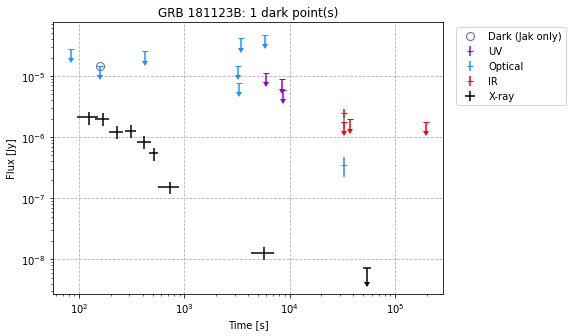

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
300,181123B,158.5,0.056227,"0.3172461047942834 (+0.06562468296156632, -inf)","1.0499999999999998 (+0.3, -0.25)",1.41,True,False


1 0 0


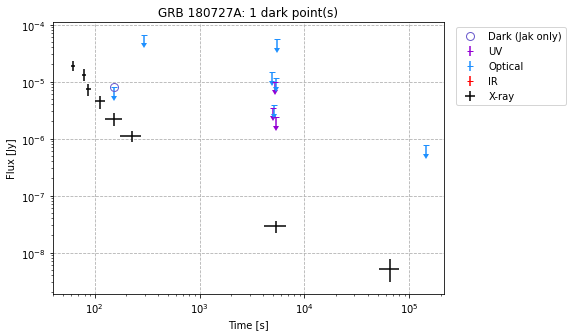

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
305,180727A,152.0,0.011286,"0.20493517918355417 (+0.04999241805790475, -inf)",0.8 ± 0.4,1.38,True,False


0 0 1


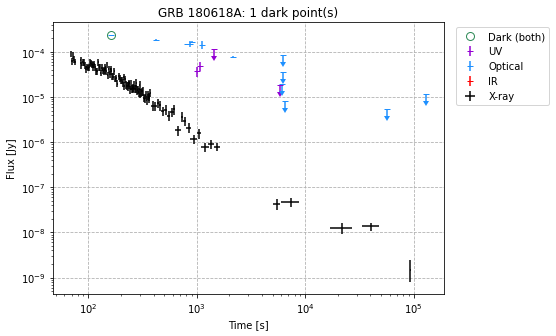

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
322,180618A,161.0,0.001487,"0.27018177347071626 (+0.044748596060879525, -0...","1.2200000000000002 (+0.25, -0.23)",1.0,True,True


1 0 1


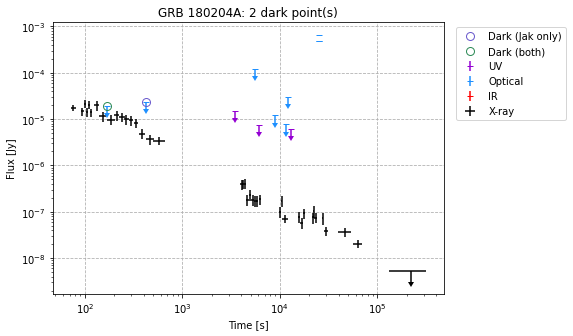

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
743,180204A,429.0,0.085590,"0.2976121359239437 (+0.0669183799716711, -inf)","0.96 (+0.21, -0.2)",1.073,True,False
740,180204A,167.0,0.088473,"0.08172057145899969 (+0.05496415412971782, -inf)","0.96 (+0.21, -0.2)",1.073,True,True


0 0 2


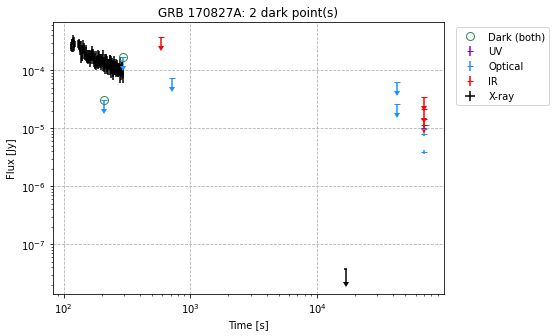

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
902,170827A,295.0,0.001141,"0.10113836807528154 (+0.031919487075984604, -inf)","1.2200000000000002 (+0.06, -0.05)",1.19,True,True
812,170827A,209.0,0.001620,"-0.2203397298098377 (+0.039224001726319235, -inf)","1.2200000000000002 (+0.06, -0.05)",1.19,True,True


5 0 2


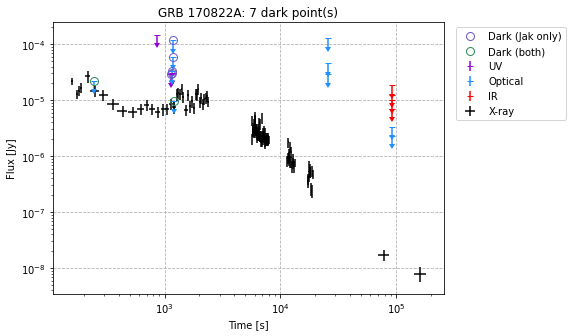

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
912,170822A,1137.5,0.001324,"0.2065382858770375 (+0.04815774499357656, -inf)",0.75 ± 0.09,1.0,True,False
953,170822A,1211.5,0.002565,"0.04369080569880635 (+0.037141690846088274, -inf)",0.75 ± 0.09,1.0,True,True
904,170822A,246.0,0.006438,"0.06632866150371261 (+0.03639487458237827, -inf)",0.75 ± 0.09,1.0,True,True
920,170822A,1151.0,0.010528,"0.22706388940018976 (+0.05233729809930151, -inf)",0.75 ± 0.09,1.0,True,False
945,170822A,1187.0,0.017710,"0.3255730795351884 (+0.055866177654593896, -inf)",0.75 ± 0.09,1.0,True,False
928,170822A,1162.5,0.020625,"0.21899768108077097 (+0.04788721575958571, -inf)",0.75 ± 0.09,1.0,True,False
936,170822A,1171.0,0.028088,"0.39480341427967713 (+0.06132345443956887, -inf)",0.75 ± 0.09,1.0,True,False


16 0 15


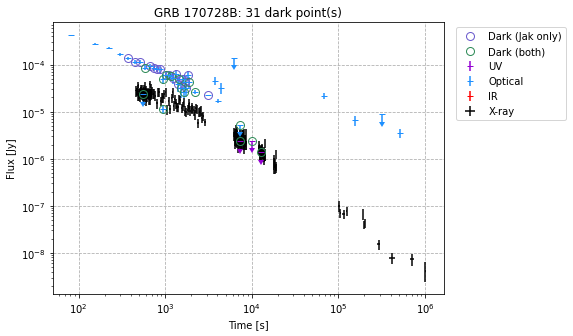

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1353,170728B,1462.0,0.000612,"0.1426827652097761 (+0.05062247198499502, -0.1...","0.79 (+0.08, -0.07)",0.69,True,True
1287,170728B,1098.0,0.000753,"0.1880439941277033 (+0.04822576227458518, -0.1...","0.79 (+0.08, -0.07)",0.69,True,False
1058,170728B,548.0,0.000851,"0.018743704294551102 (+0.0293360417086443, -inf)","0.79 (+0.08, -0.07)",0.69,True,True
1407,170728B,1680.0,0.000937,"0.2080062878343111 (+0.06039849631156196, -0.1...","0.79 (+0.08, -0.07)",0.69,True,False
1251,170728B,951.0,0.001066,"-0.08822109794538191 (+0.04782750223789055, -0...","0.79 (+0.08, -0.07)",0.69,True,True
1004,170728B,517.0,0.001554,"0.2273142050325974 (+0.04208145045713396, -0.1...","0.79 (+0.08, -0.07)",0.69,True,False
1174,170728B,662.0,0.001591,"0.24596624607770318 (+0.04461074272014205, -0....","0.79 (+0.08, -0.07)",0.69,True,False
1534,170728B,7255.0,0.001850,"-0.01582405611031937 (+0.03987156245090574, -inf)","0.79 (+0.08, -0.07)",1.31,True,True
1631,170728B,12764.0,0.001985,"-0.013787394671253103 (+0.038599033560890866, ...","0.79 (+0.08, -0.07)",1.31,True,True
1464,170728B,2190.0,0.001990,"0.1635409009988904 (+0.04245678763528685, -0.1...","0.79 (+0.08, -0.07)",0.69,True,True


1 0 0


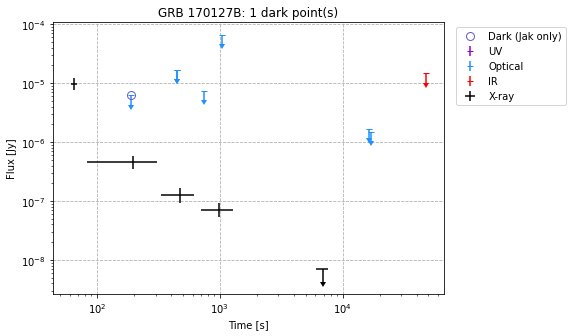

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1656,170127B,189.0,0.033184,"0.41573286666215475 (+0.07187030642336034, -inf)","0.5900000000000001 (+0.48, -0.24)",1.9,True,False


2 0 0


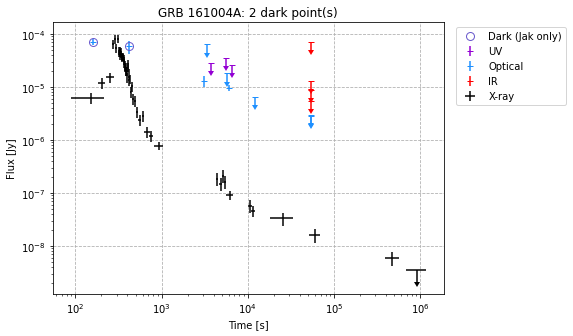

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1677,161004A,422.0,0.006133,"0.2271069800104917 (+0.061431669756167734, -0....","0.55 (+0.17, -0.15)",1.04,True,False
1660,161004A,160.0,0.049511,"0.3880093011510872 (+0.06981752143036461, -0.2...","0.55 (+0.17, -0.15)",1.04,True,False


1 0 0


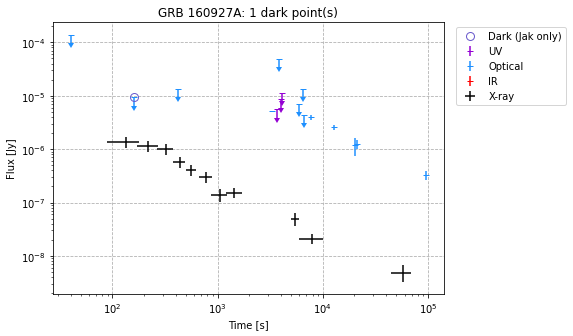

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1708,160927A,160.0,0.186486,"0.3043567855111735 (+0.09307714658151692, -inf)","0.6399999999999999 (+0.3, -0.14)",1.02,True,False


1 0 3


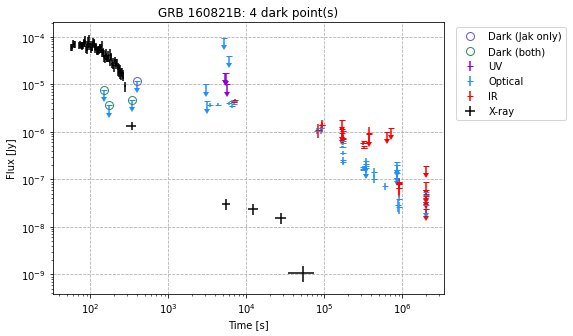

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1727,160821B,151.0,0.006749,"-0.24751830582012946 (+0.04262286347909809, -inf)","1.2000000000000002 (+0.28, -0.24)",2.11,True,True
1750,160821B,172.8,0.006823,"-0.3891564442367287 (+0.05869908696221627, -inf)","1.2000000000000002 (+0.28, -0.24)",2.11,True,True
1763,160821B,345.6,0.013968,"0.20504740497975443 (+0.04286303429745854, -inf)","1.2000000000000002 (+0.28, -0.24)",2.11,True,True
1764,160821B,394.5,0.157438,"0.35364396325784125 (+0.14527064340318116, -inf)","1.2000000000000002 (+0.28, -0.24)",2.11,True,False


2 0 0


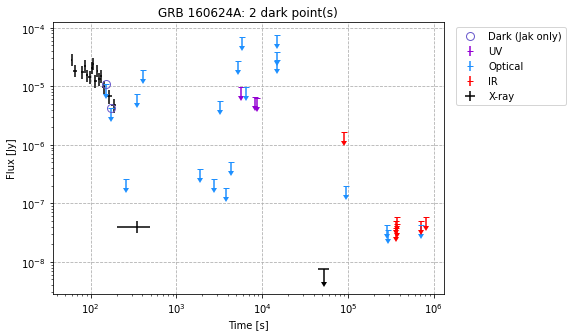

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1777,160624A,172.8,0.058227,"-0.07121833377450945 (+0.1012355407851191, -inf)","0.6000000000000001 (+0.5, -0.4)",3.74,True,False
1774,160624A,152.0,0.066876,"0.016029122534107675 (+0.11115362302302455, -inf)","0.6000000000000001 (+0.5, -0.4)",3.74,True,False


1 0 0


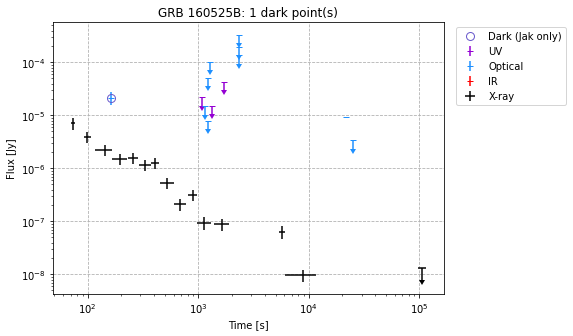

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1783,160525B,163.0,0.147346,"0.3610739023388736 (+0.11017183909020013, -0.2...","0.93 (+0.27, -0.25)",1.37,True,False


1 0 0


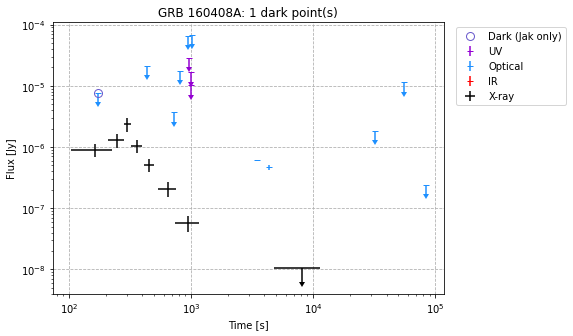

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1802,160408A,173.0,0.054962,"0.34126947057766777 (+0.07021671202580732, -inf)","1.1 (+0.4, -0.3)",1.6,True,False


3 0 2


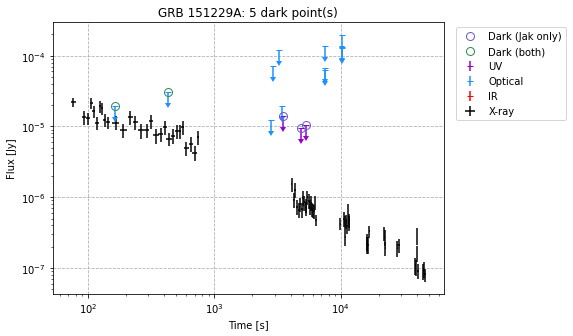

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1813,151229A,165.0,0.009318,"0.08551899905655155 (+0.037419935813016, -inf)",1.0299999999999998 ± 0.14,0.497,True,True
1850,151229A,5291.0,0.028029,"0.4071019177413437 (+0.07184062813821807, -inf)",1.0299999999999998 ± 0.14,0.950,True,False
1832,151229A,4881.5,0.031033,"0.39686586671525803 (+0.07174070230114254, -inf)",1.0299999999999998 ± 0.14,0.950,True,False
1817,151229A,427.0,0.031102,"0.24419921461541721 (+0.04852536123990434, -inf)",1.0299999999999998 ± 0.14,0.497,True,True
1822,151229A,3497.5,0.146797,"0.37349966154078273 (+0.08609566500155641, -inf)",1.0299999999999998 ± 0.14,0.950,True,False


1 0 0


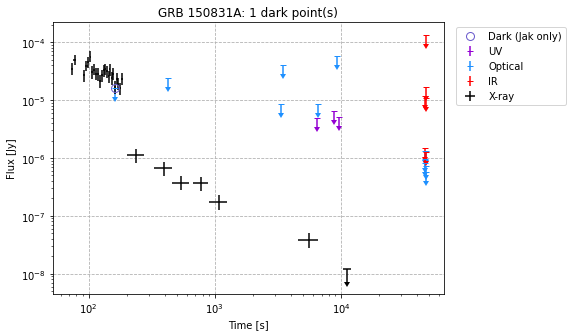

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1898,150831A,163.0,0.01047,"-0.00714602404155144 (+0.038790906752000344, -...","0.8 (+0.5, -0.4)",1.18,True,False


4 0 4


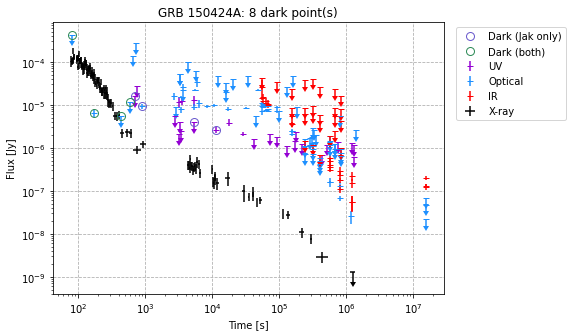

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
1938,150424A,174.0,0.002791,"-0.27448807935892167 (+0.055530401460026926, -...","1.02 (+0.18, -0.17)",2.57,True,True
1912,150424A,82.0,0.006095,"0.2015741817773901 (+0.035108501717430796, -inf)","1.02 (+0.18, -0.17)",1.00,True,True
1956,150424A,601.0,0.010159,"0.25717748383674716 (+0.05148722044503181, -inf)","1.02 (+0.18, -0.17)",2.57,True,True
1996,150424A,5269.0,0.015721,"0.41688337470830356 (+0.0724799973919687, -inf)","1.02 (+0.18, -0.17)",0.71,True,False
1953,150424A,436.0,0.038665,"0.14382370926139018 (+0.059709905069334, -inf)","1.02 (+0.18, -0.17)",2.57,True,True
1965,150424A,890.0,0.047015,"0.3218880254239244 (+0.05866754227510491, -0.2...","1.02 (+0.18, -0.17)",0.71,True,False
2064,150424A,11320.0,0.127508,"0.36728961595065684 (+0.08121918460129696, -0....","1.02 (+0.18, -0.17)",0.71,True,False
1959,150424A,714.0,0.175951,"0.34188446324264177 (+0.08174533030654704, -inf)","1.02 (+0.18, -0.17)",0.71,True,False


0 0 1


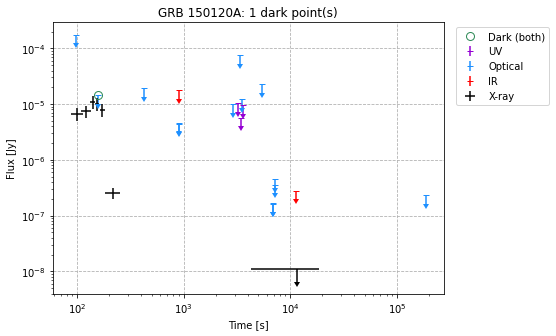

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2201,150120A,158.0,0.022462,"0.05687691449590588 (+0.0586804064924505, -inf)","1.1 (+0.5, -0.4)",4.38,True,True


1 0 0


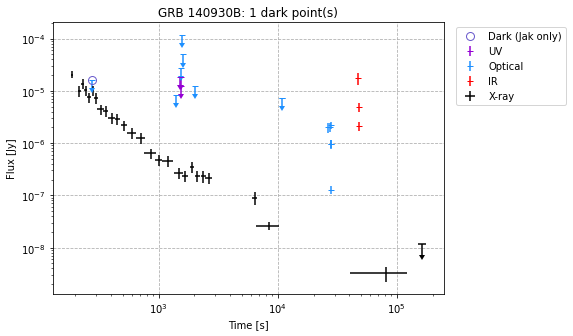

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2213,140930B,276.0,0.014074,"0.0715626635639951 (+0.038461031940199515, -inf)","0.69 (+0.18, -0.16)",1.74,True,False


6 0 0


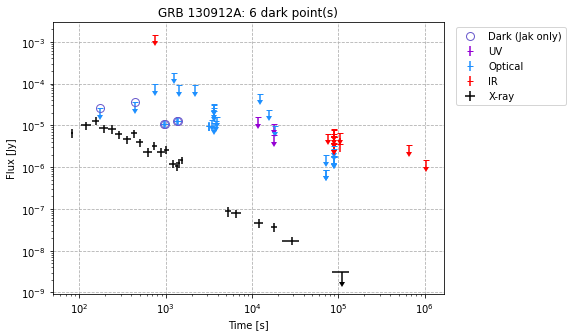

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2314,130912A,436.0,0.014383,"0.2771099513853195 (+0.05124674465275888, -inf)","0.44 (+0.21, -0.11)",1.463,True,False
2330,130912A,1368.0,0.018486,"0.36902922012024353 (+0.0646362100262244, -0.2...","0.44 (+0.21, -0.11)",1.463,True,False
2334,130912A,1380.0,0.027420,"0.3660680269309475 (+0.06461608223225399, -0.2...","0.44 (+0.21, -0.11)",1.463,True,False
2323,130912A,972.0,0.044131,"0.2060708720656901 (+0.05833002401703149, -0.1...","0.44 (+0.21, -0.11)",1.463,True,False
2321,130912A,960.0,0.055932,"0.20673641485801725 (+0.061087462688075155, -0...","0.44 (+0.21, -0.11)",1.463,True,False
2313,130912A,174.0,0.097581,"0.1746980607505951 (+0.04296237884195829, -inf)","0.44 (+0.21, -0.11)",0.270,True,False


3 0 1


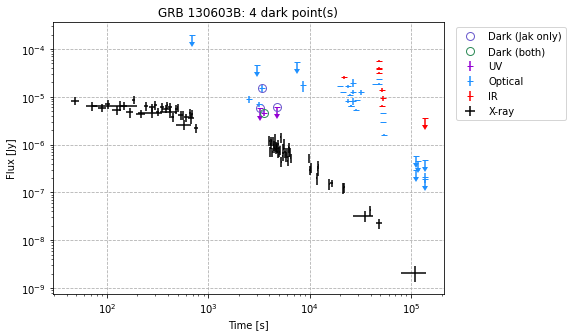

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2395,130603B,4778.5,0.003995,"0.33880141952937537 (+0.0629770469721706, -inf)","0.97 (+0.14, -0.13)",1.0,True,False
2377,130603B,3567.5,0.107029,"0.2347214234161625 (+0.07196853096636334, -0.2...","0.97 (+0.14, -0.13)",1.0,True,True
2373,130603B,3371.0,0.156214,"0.3960732673214488 (+0.09202276246160318, -0.3...","0.97 (+0.14, -0.13)",1.0,True,False
2372,130603B,3228.0,0.192008,"0.26394949664177414 (+0.09270423714248009, -inf)","0.97 (+0.14, -0.13)",1.0,True,False


0 0 1


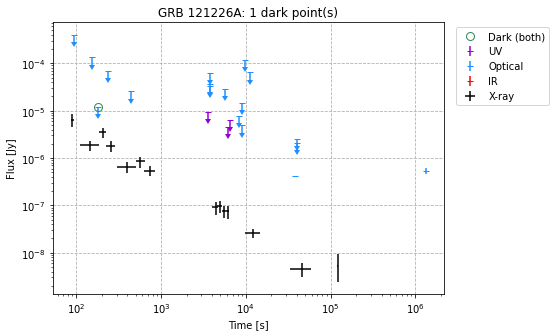

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2454,121226A,179.0,0.134643,"0.19939931994173682 (+0.07480697875377806, -inf)",1.4 ± 0.4,1.04,True,True


2 0 1


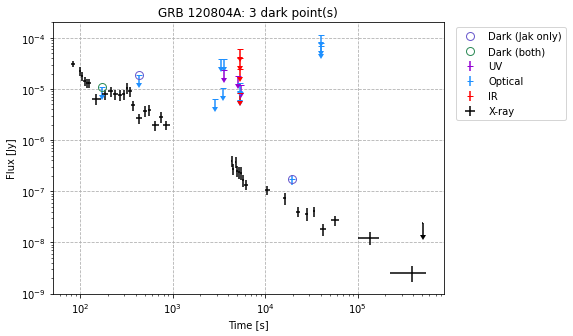

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2477,120804A,435.0,0.000324,"0.31298462658694176 (+0.05647329959621704, -inf)","0.96 (+0.21, -0.2)",1.095,True,False
2474,120804A,172.0,0.074672,"0.05628116489174747 (+0.04997721072854521, -inf)","0.96 (+0.21, -0.2)",1.095,True,True
2546,120804A,19800.0,0.123502,"0.20771521169885515 (+0.07555282701288185, -0....","0.96 (+0.21, -0.2)",1.095,True,False


1 0 0


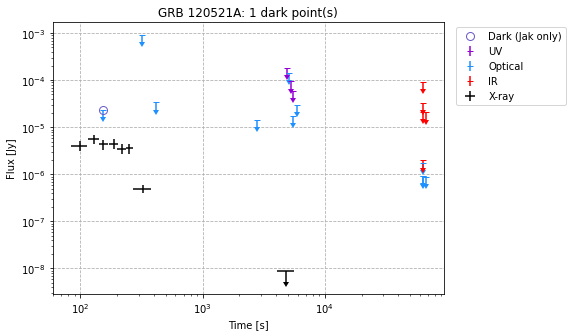

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2555,120521A,152.0,0.012795,"0.2651610920387164 (+0.05125032743714506, -inf)","0.74 (+0.33, -0.19)",1.81,True,False


0 0 2


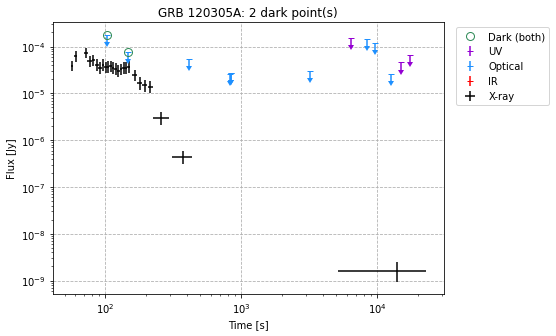

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2576,120305A,146.5,0.013328,"0.11611174953625314 (+0.04256203635582088, -inf)","1.7999999999999998 (+0.7, -0.5)",1.0,True,True
2567,120305A,102.6,0.021263,"0.23434243239078842 (+0.04827035871211284, -inf)","1.7999999999999998 (+0.7, -0.5)",1.0,True,True


1 0 0


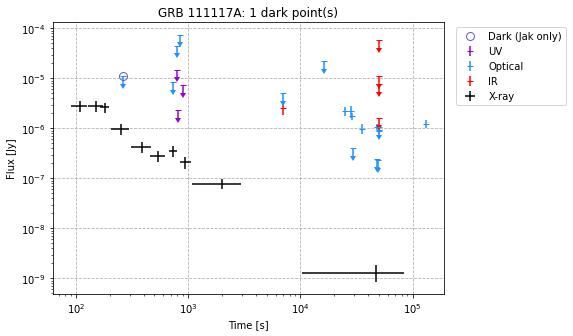

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2627,111117A,262.0,0.043833,"0.39050489907780483 (+0.0692247526003332, -inf)","0.8400000000000001 (+0.28, -0.26)",1.27,True,False


0 0 1


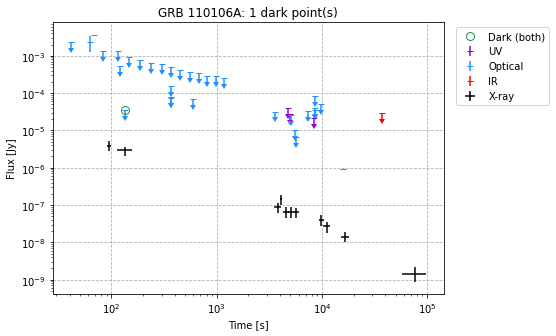

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2692,110106A,136.0,0.004847,"0.3955148107219521 (+0.06799658258436435, -inf)",1.5 ± 0.5,1.11,True,True


1 0 0


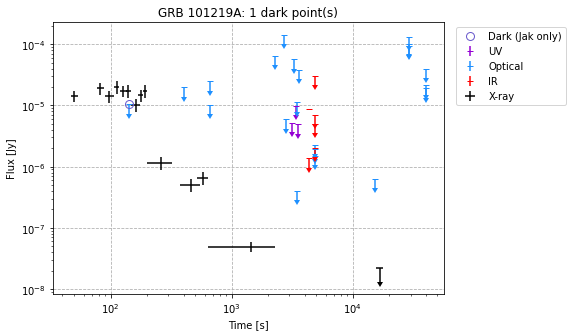

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2718,101219A,142.0,0.013309,"-0.08032539371266006 (+0.040495150670132395, -...","0.46 (+0.26, -0.24)",1.67,True,False


1 0 0


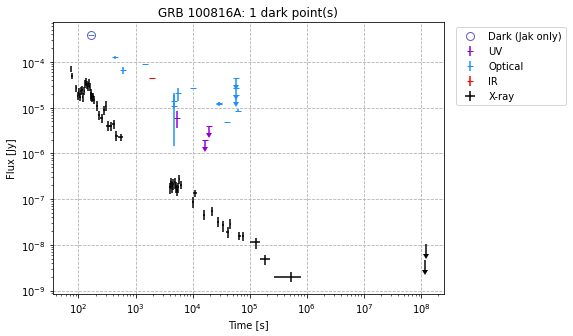

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2728,100816A,166.0,0.052778,"0.4088238719473531 (+0.06815883613577527, -0.3...","0.81 (+0.17, -0.16)",1.184,True,False


1 0 0


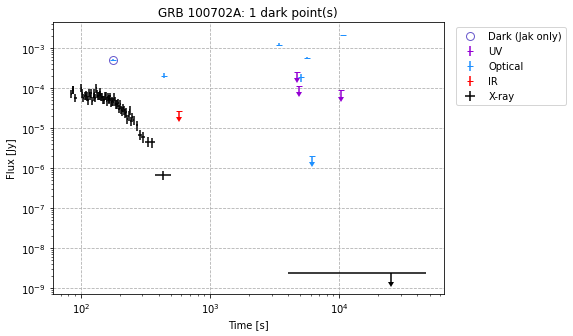

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2795,100702A,176.0,0.00405,"0.3762568652979101 (+0.062115099329621296, -0....","1.2999999999999998 (+0.6, -0.5)",2.9,True,False


0 1 1


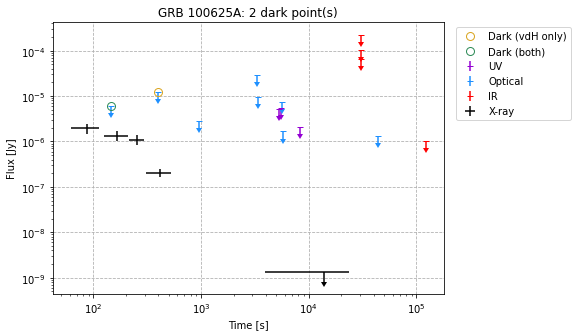

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2810,100625A,394.0,0.059538,"0.661307473055828 (+0.10092550933649874, -inf)","1.6 (+0.4, -0.3)",1.45,False,True
2809,100625A,146.5,0.118304,"0.23921578602800378 (+0.08643968662355281, -inf)","1.6 (+0.4, -0.3)",1.45,True,True


0 0 1


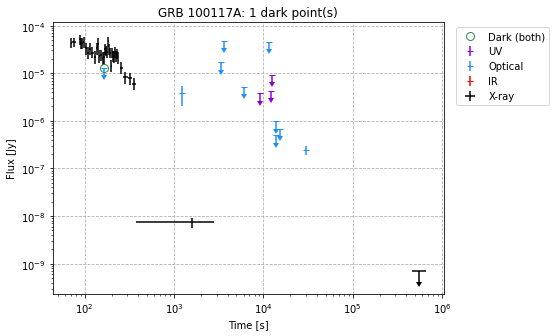

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2819,100117A,163.5,0.003735,"-0.08384044747938293 (+0.04582344545091654, -inf)","1.7000000000000002 (+0.6, -0.5)",1.0,True,True


0 0 1


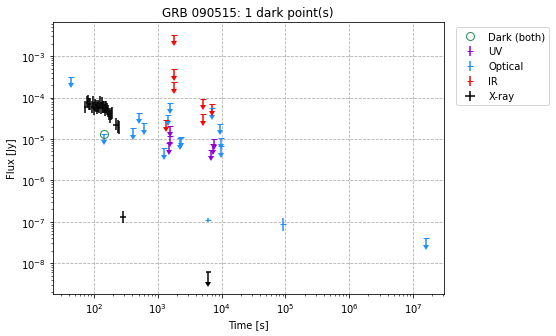

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2841,090515,141.5,0.007089,"-0.2287223009743839 (+0.05486187789698157, -inf)","1.5699999999999998 (+1.19, -0.68)",4.49,True,True


9 0 0


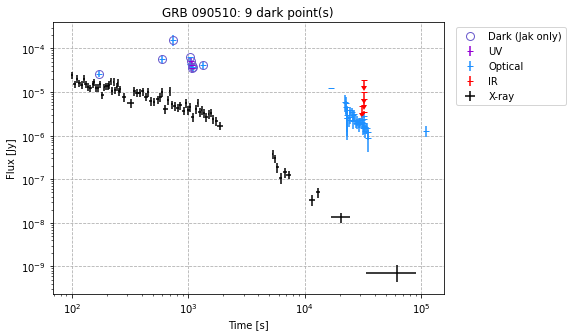

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
2869,090510,598.0,0.002051,"0.2830830381506375 (+0.061043597051168914, -0....",0.6799999999999999 ± 0.12,0.66,True,False
2893,090510,1048.0,0.003188,"0.4174284916801267 (+0.08014109114776326, -0.3...",0.6799999999999999 ± 0.12,0.66,True,False
2921,090510,1094.5,0.003483,"0.4205399973673835 (+0.07172437802329212, -0.3...",0.6799999999999999 ± 0.12,0.66,True,False
2885,090510,1033.0,0.011171,"0.4055768160779434 (+0.06336317724028344, -inf)",0.6799999999999999 ± 0.12,0.66,True,False
2930,090510,1346.5,0.017940,"0.3961574973703175 (+0.06958701930388769, -0.3...",0.6799999999999999 ± 0.12,0.66,True,False
2860,090510,172.0,0.018360,"0.08784455192610077 (+0.04083739134265433, -0....",0.6799999999999999 ± 0.12,0.66,True,False
2902,090510,1069.5,0.023768,"0.3472639831311582 (+0.07506029538187704, -0.2...",0.6799999999999999 ± 0.12,0.66,True,False
2911,090510,1083.0,0.036691,"0.38503942675918235 (+0.0756545234153078, -0.3...",0.6799999999999999 ± 0.12,0.66,True,False
2876,090510,745.0,0.071705,"0.41009535114613066 (+0.07869745452520159, -0....",0.6799999999999999 ± 0.12,0.66,True,False


4 0 1


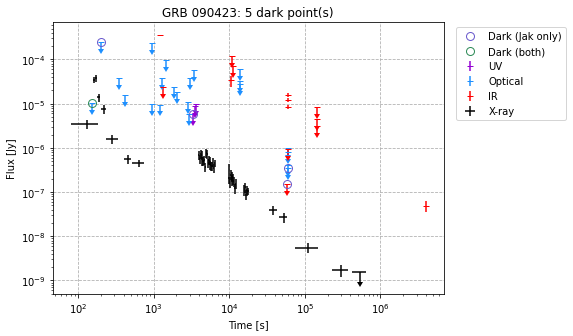

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3065,090423,200.0,0.059277,"0.4220631211100543 (+0.0610898281985447, -inf)",0.71 ± 0.13,0.00,True,False
3061,090423,152.0,0.073001,"-0.19625502204644998 (+0.03786611839727725, -inf)",0.71 ± 0.13,0.00,True,True
3133,090423,58500.0,0.118792,"0.23958836645575843 (+0.0816700617834125, -inf)",0.71 ± 0.13,1.41,True,False
3136,090423,60120.0,0.149773,"0.3816049476006451 (+0.10400469637947642, -inf)",0.71 ± 0.13,1.41,True,False
3068,090423,3276.0,0.171292,"0.3778416196377353 (+0.06813196395948531, -inf)",0.71 ± 0.13,0.00,True,False


8 0 0


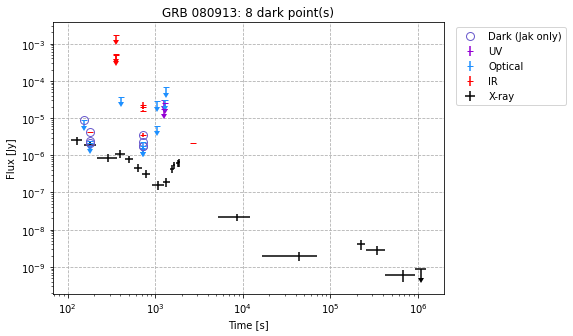

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3148,080913,180.0,0.004001,"0.01605618847209473 (+0.03403045409397591, -inf)","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3149,080913,180.0,0.004001,"0.03748108498254906 (+0.03320026502328483, -inf)","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3150,080913,180.0,0.004001,"0.11163150427182805 (+0.034671043221582876, -0...","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3157,080913,720.0,0.087132,"0.26489000672688745 (+0.06617518208200589, -inf)","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3159,080913,720.0,0.087132,"0.2529994851385232 (+0.063786632288824, -inf)","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3161,080913,720.0,0.087132,"0.284634977772599 (+0.06459595553754059, -inf)","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3163,080913,720.0,0.087132,"0.3402391403389642 (+0.07010107929381086, -0.2...","0.6599999999999999 (+0.23, -0.2)",1.2,True,False
3147,080913,155.0,0.142334,"0.2399314397193824 (+0.08439495698970656, -inf)","0.6599999999999999 (+0.23, -0.2)",1.2,True,False


0 0 2


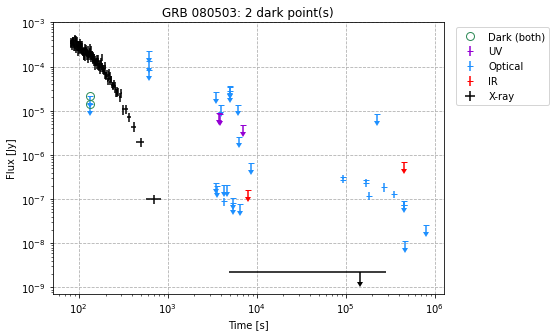

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3212,080503,133.2,0.001207,"-0.41446458075626785 (+0.060428715663389795, -...","1.4500000000000002 (+0.32, -0.24)",1.64,True,True
3268,080503,134.5,0.002226,"-0.3717373566638188 (+0.05574912379071332, -inf)","1.4500000000000002 (+0.32, -0.24)",1.64,True,True


0 0 2


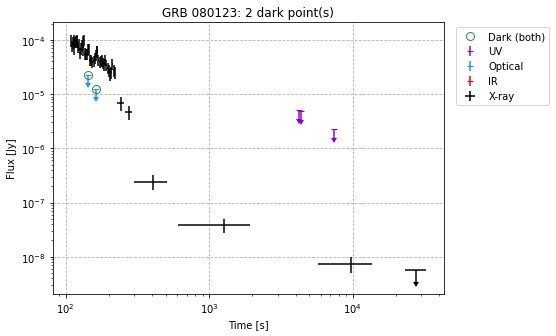

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3338,080123,161.5,0.003585,"-0.22627806369666828 (+0.046454181530070186, -...","1.4 (+0.6, -0.5)",2.2,True,True
3315,080123,144.0,0.005923,"-0.16940545058698822 (+0.04211980335327065, -inf)","1.4 (+0.6, -0.5)",2.2,True,True


3 0 0


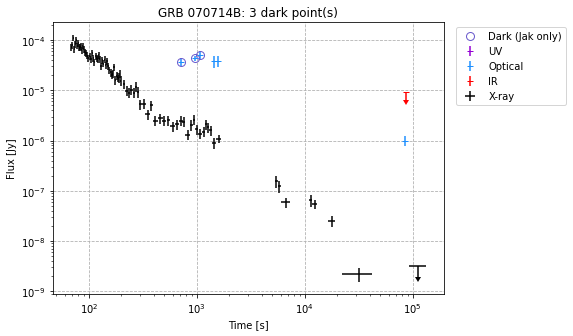

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3375,070714B,720.0,0.012677,"0.39916262385394813 (+0.0647347348599059, -0.2...","0.93 (+0.15, -0.14)",0.68,True,False
3381,070714B,972.0,0.030904,"0.4136912567490476 (+0.0630702275998364, -0.29...","0.93 (+0.15, -0.14)",0.68,True,False
3385,070714B,1080.0,0.145449,"0.42357094828688363 (+0.07569030453470793, -0....","0.93 (+0.15, -0.14)",0.68,True,False


0 0 2


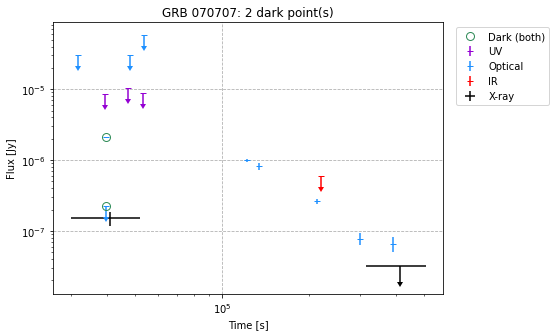

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3400,070707,39600.0,0.034146,"0.05835654003573679 (+0.035283999442822477, -inf)","1.86 (+1.71, -0.57)",1.0,True,True
3401,070707,39600.0,0.034146,"0.3870179453790122 (+0.05831681402895094, -0.2...","1.86 (+1.71, -0.57)",1.0,True,True


4 0 0


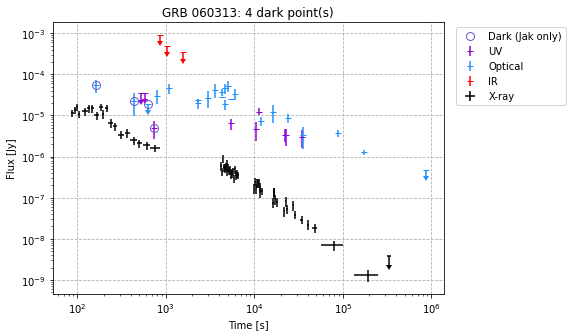

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3433,060313,432.0,0.004432,"0.35707675308867254 (+0.11049834993494674, -0....","0.8460000000000001 (+0.12, -0.087)",1.0,True,False
3429,060313,162.0,0.022188,"0.25537158441562124 (+0.06979786317533948, -0....","0.8460000000000001 (+0.12, -0.087)",1.0,True,False
3441,060313,739.0,0.023547,"0.20120618337611967 (+0.09275371685417784, -0....","0.8460000000000001 (+0.12, -0.087)",1.0,True,False
3439,060313,629.5,0.028395,"0.37546685197672236 (+0.06330506308398082, -inf)","0.8460000000000001 (+0.12, -0.087)",1.0,True,False


10 0 29


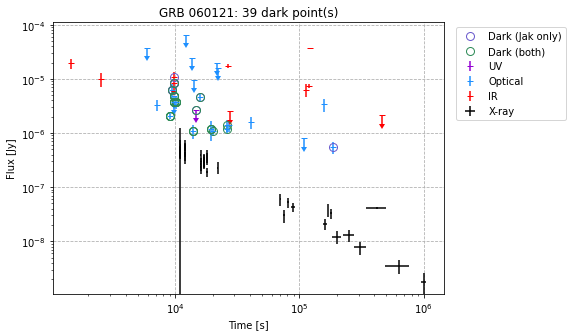

,GRB,t_o,dt%,B_ox_w_err,B_x,α,Jak_dark,vdH_dark
3721,060121,15840.0,0.010000,"0.4162778870451809 (+0.06842103710074385, -0.2...","1.17 (+0.24, -0.23)",1.0,True,False
3723,060121,15840.0,0.010000,"0.36229035276870697 (+0.06380856713854031, -0....","1.17 (+0.24, -0.23)",1.0,True,True
3753,060121,185400.0,0.030000,"0.41305105261907854 (+0.07142370259938115, -0....","1.17 (+0.24, -0.23)",1.0,True,False
3733,060121,19440.0,0.080000,"0.18515305072630436 (+0.08181169915468307, -0....","1.17 (+0.24, -0.23)",1.0,True,True
3734,060121,19440.0,0.080000,"0.1688234528518031 (+0.08138640783527644, -0.1...","1.17 (+0.24, -0.23)",1.0,True,True
3735,060121,19440.0,0.080000,"0.27058789515120013 (+0.08184180310594405, -0....","1.17 (+0.24, -0.23)",1.0,True,True
3712,060121,14713.0,0.080437,"0.40497455232135426 (+0.08147813331600313, -inf)","1.17 (+0.24, -0.23)",1.0,True,False
3714,060121,14713.0,0.080437,"0.340172749514363 (+0.07501470416463918, -inf)","1.17 (+0.24, -0.23)",1.0,True,True
3659,060121,10080.0,0.083636,"0.26406120697463453 (+0.06960457752141125, -0....","1.17 (+0.24, -0.23)",1.0,True,True
3660,060121,10080.0,0.083636,"0.3187306680140073 (+0.07266163646949922, -0.2...","1.17 (+0.24, -0.23)",1.0,True,True


In [8]:
for grb in close_times["GRB"].unique():
    fig, ax = plt.subplots(figsize=(7,5))

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")

    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    print(len(jak),len(vdh),len(both))
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()
    display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])

In [24]:
def interp_xray_flux(grb,time):
    lightcurve = xrt_data[xrt_data["GRB"]==grb]
    time_series = [lightcurve.loc[i,"Time"] for i in lightcurve.index if np.isfinite(lightcurve.loc[i,"SpecFlux"].minus)]
    flux_series = [Fx.value for Fx in lightcurve["SpecFlux"] if np.isfinite(Fx.minus)]
    interp_func = interpolate.interp1d(time_series,flux_series)
    return interp_func(time)

def interp_B_ox(optical_index):
    grb = all_optical.loc[optical_index,"GRB"]
    t_o = all_optical.loc[optical_index,"Time (s)"]
    F_o = all_optical.loc[optical_index,"Flux (Jy)"]
    print("B_x",results.loc[results["GRB"]==grb,"B_x"])
    print(grb,t_o,F_o)
    F_x = interp_xray_flux(grb,t_o)
    nu_o = 299792458/float(all_optical.loc[optical_index,"λ_eff"]/1e10)
    return -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)

def bpl(xvals,alphas,breaks):
    assert len(alphas)==len(breaks)+1, "There must be one more index than there are breaks"
    assert min(xvals)<min(breaks) and max(xvals)>max(breaks), "Breaks must be within domain"
    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)] # create a list of all the bounding x-values
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]
    
    all_y = []
    
    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals) # add this piece to the output
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0]) # scale the beginning of each piece to the end of the last so it is continuous
    
    return np.array([y for ychunk in all_y for y in ychunk]) # return flattened list

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
11,210410A,1042113,Johnson,RATIR,r,6149.31,31518.0,23.79,0.3,GCN 29784,0.05,0.114819,23.79 ± 0.3,1.2301383194065202e-06 ± 3.3989977879034427e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


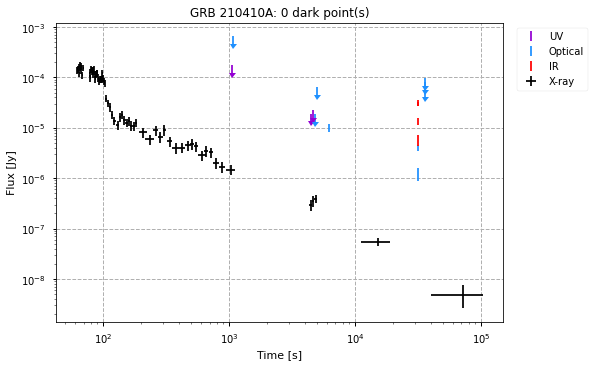

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
37,210323A,1038247,Gemini North,GMOS,r,6224.52,62208.0,24.6,0.2,GCN 29720,0.131,0.296007,24.6 ± 0.2,6.893331537774699e-07 ± 1.2697985951956597e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


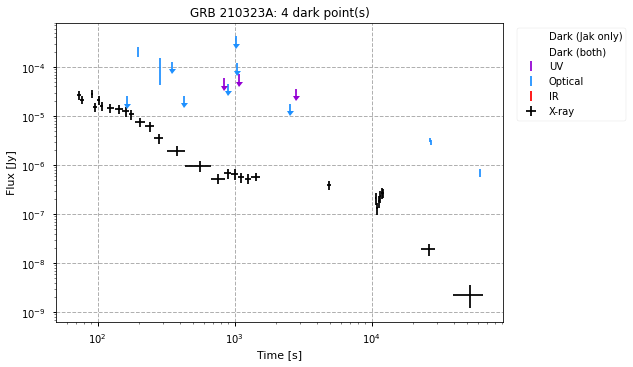

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
54,201221D,1014037,NOT,ALFOSC,r,6141.12,6012.0,23.1,0.3,GCN 29117,0.02,0.046046,23.1 ± 0.3,2.1799401461112093e-06 ± 6.023397220865919e-07
60,201221D,1014037,Discovery,LMI,r,6141.12,36396.0,23.9,0,GCN 29128,0.02,0.046046,23.9 ± 0.0,1.0433849533910372e-06 ± 0.0
61,201221D,1014037,Discovery,LMI,i,7457.89,36396.0,23.7,0,GCN 29128,0.02,0.034223,23.7 ± 0.0,1.2408392388138238e-06 ± 0.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


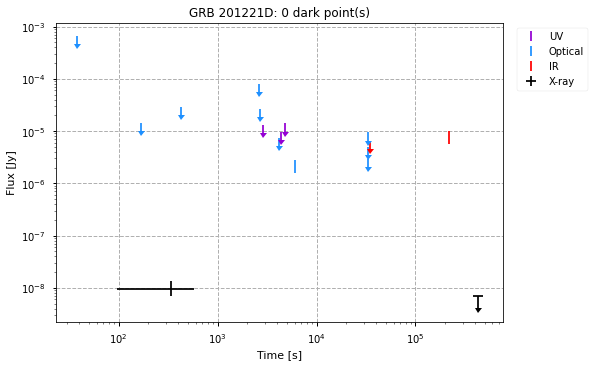

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
96,201006A,998907,Discovery,LMI,i,7457.89,124416.0,23.8,3-sigma,GCN 28572,1.27,2.173172,"23.8 (+inf, -0.0)","8.1151186884704e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


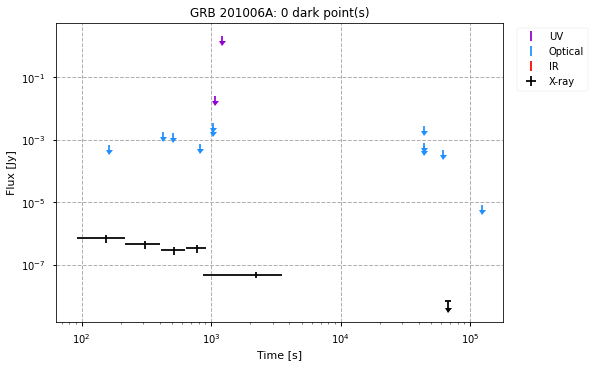

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
139,200522A,973628,Hubble,WFC3,F125W,12364.65,299808.0,24.90,0.08,arXiv:2012.00026,0.03,0.021679,24.9 ± 0.08,4.0616070630785857e-07 ± 2.992702680654105e-08
140,200522A,973628,Hubble,WFC3,F125W,12364.65,304128.0,24.53,0.15,2021ApJ...906..127F,0.03,0.021679,24.53 ± 0.15,5.710812555030189e-07 ± 7.889779114857451e-08
142,200522A,973628,Hubble,WFC3,NaN,15279.08,311040.0,23.70,NaN,GCN 27826,0.03,0.015330,"23.7 (+nan, -nan)","1.2194343881858644e-06 (+nan, -nan)"
143,200522A,973628,Hubble,WFC3,F125W,12364.65,311040.0,23.80,0.3,GCN 27827,0.03,0.021679,23.8 ± 0.3,1.1186594754812014e-06 ± 3.090970358855463e-07
144,200522A,973628,Hubble,WFC3,F160W,15279.08,311904.0,24.71,0.07,arXiv:2012.00026,0.03,0.015330,24.71 ± 0.07,4.81014798821612e-07 ± 3.101217014773287e-08
145,200522A,973628,Hubble,WFC3,F160W,15279.08,316224.0,24.61,0.15,2021ApJ...906..127F,0.03,0.015330,24.61 ± 0.15,5.274222389300992e-07 ± 7.286607510443941e-08
146,200522A,973628,Hubble,WFC3,F125W,12364.65,1410048.0,27.20,3-sigma,arXiv:2012.00026,0.03,0.021679,"27.2 (+inf, -0.0)","4.883125719330247e-08 (+0.0, -inf)"
147,200522A,973628,Hubble,WFC3,F125W,12364.65,1415232.0,27.50,3-sigma,2021ApJ...906..127F,0.03,0.021679,"27.5 (+inf, -0.0)","3.704229666732184e-08 (+0.0, -inf)"
148,200522A,973628,Hubble,WFC3,NaN,12364.65,1416960.0,26.80,<3-sigma,GCN 27904,0.03,0.021679,"26.8 (+inf, -0.0)","7.058264120272258e-08 (+0.0, -inf)"
149,200522A,973628,Hubble,WFC3,NaN,12364.65,1416960.0,28.10,<3-sigma,GCN 27904,0.03,0.021679,"28.1 (+inf, -0.0)","2.1315616873068047e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


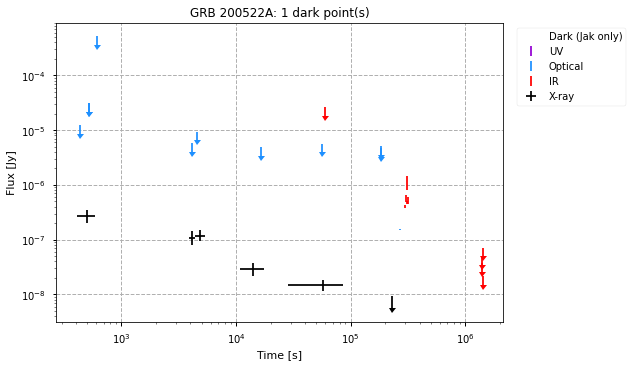

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
189,191031D,932608,MMT,Binospec,r,NaN,15516.0,23.50,3-sigma,GCN 26134,0.08,NaN,"23.5 (+inf, -0.0)","nan (+nan, -nan)"
190,191031D,NaN,MMT,Binospec,r,6122.940,15552.0,24.10,3-sigma,Rastinejad,0.08,0.185232,"24.1 (+inf, -0.0)","9.865497528567421e-07 (+0.0, -inf)"
193,191031D,NaN,HJT,RATIR,i,7531.293,18144.0,23.10,3-sigma,Rastinejad,0.08,0.134263,"23.1 (+inf, -0.0)","2.364456394798117e-06 (+0.0, -inf)"
195,191031D,932608,Johnson,RATIR,i,7531.290,18252.0,23.17,3-sigma,GCN 26121,0.08,0.134263,"23.17 (+inf, -0.0)","2.2168246563739915e-06 (+0.0, -inf)"
204,191031D,NaN,MMT,Binospec,r,6122.940,102816.0,24.40,3-sigma,Rastinejad,0.08,0.185232,"24.4 (+inf, -0.0)","7.483745191677094e-07 (+0.0, -inf)"
205,191031D,NaN,Gemini-N,GMOS,r,6224.520,112320.0,24.80,3-sigma,Rastinejad,0.08,0.180768,"24.8 (+inf, -0.0)","5.156242975052886e-07 (+0.0, -inf)"
206,191031D,932608,Gemini North,GMOS,r,6224.520,112320.0,25.00,NaN,GCN 26147,0.08,0.180768,"25.0 (+nan, -nan)","4.2887761016516436e-07 (+nan, -nan)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


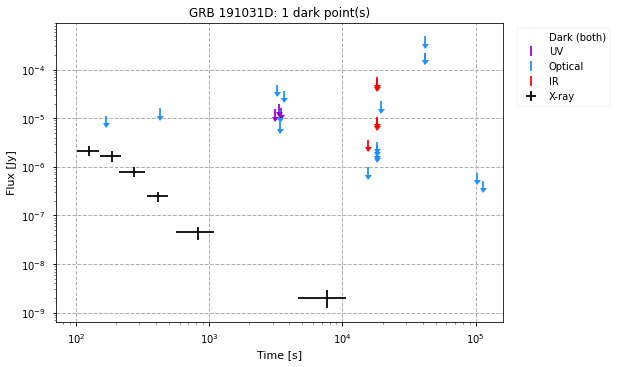

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
214,190719C,915381,NOT,ALFOSC,NaN,6141.12,129686.4,23.03,0.12,GCN 25144,0.04,0.092092,23.03 ± 0.12,2.4258441175067434e-06 ± 2.681142001391195e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


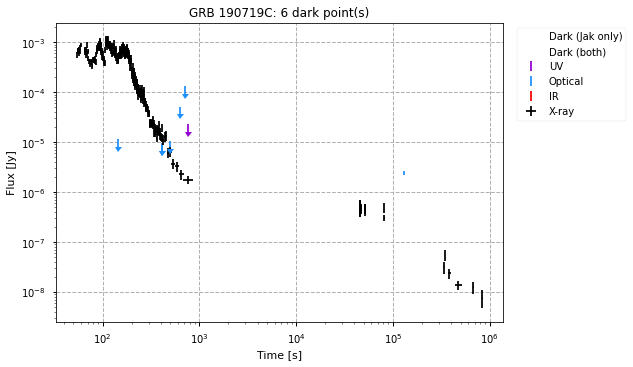

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


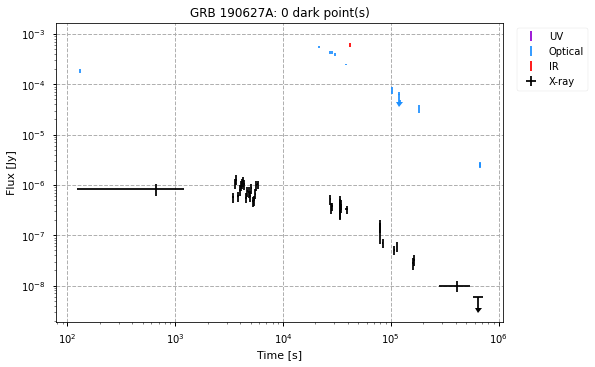

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
281,181126A,NaN,Gemini-N,GMOS,z,9571.59,15552.0,25.3,3-sigma,Rastinejad,0.07,0.078140,"25.3 (+inf, -0.0)","2.9599353322133564e-07 (+0.0, -inf)"
282,181126A,NaN,Keck I,MOSFIRE,Ks,21354.70,15552.0,23.6,3-sigma,Rastinejad,0.07,0.022192,"23.6 (+inf, -0.0)","1.3455604272546054e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


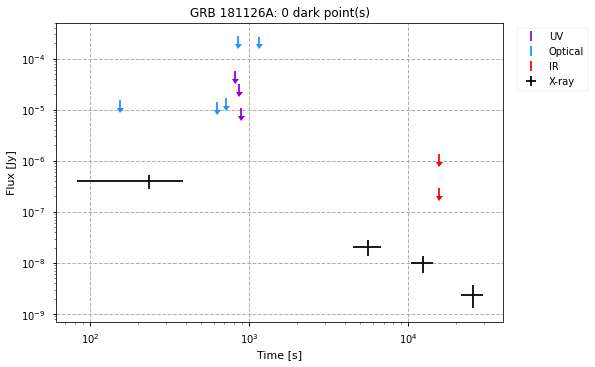

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
294,181123B,873186,Gemini North,GMOS,i,7713.830,32832.0,25.10,0.39,2020ApJ...898L..32P,0.03,0.048439,25.1 ± 0.39,3.4625970047727575e-07 ± 1.2437761824127513e-07
295,181123B,873186,Gemini North,GMOS,i,7713.830,33120.0,23.32,0.25,GCN 23439,0.03,0.048439,23.32 ± 0.25,1.7840291615019164e-06 ± 4.1078789527409804e-07
297,181123B,873186,Keck,MOSFIRE,J,12431.167,33120.0,23.30,3-sigma,GCN 23461,0.03,0.021449,"23.3 (+inf, -0.0)","1.7725800080287376e-06 (+0.0, -inf)"
298,181123B,873186,Keck,MOSFIRE,J,12431.167,37152.0,23.20,inf,2020ApJ...898L..32P,0.03,0.021449,"23.2 (+inf, -0.0)","1.943595329722827e-06 (+0.0, -inf)"
300,181123B,873186,MMT,MMIRS,J,12452.990,196128.0,23.30,inf,2020ApJ...898L..32P,0.03,0.021373,"23.3 (+inf, -0.0)","1.77245673911448e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


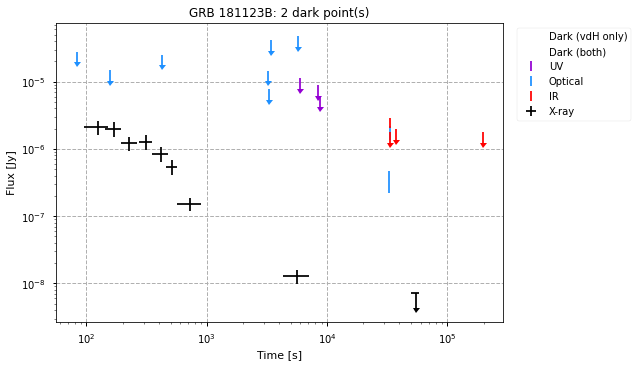

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
302,180805B,NaN,ESO,HAWK-I,J,12522.31,60480.0,24.4,3-sigma,Rastinejad,0.02,0.014117,"24.4 (+inf, -0.0)","6.39253659007889e-07 (+0.0, -inf)"
303,180805B,NaN,NTT,EFOSC2,i,7944.87,63936.0,25.0,3-sigma,Rastinejad,0.02,0.030951,"25.0 (+inf, -0.0)","3.7359968177692304e-07 (+0.0, -inf)"
304,180805B,NaN,Magellan-Baade,IMACS,r,6463.84,69120.0,24.2,3-sigma,Rastinejad,0.02,0.042990,"24.2 (+inf, -0.0)","7.892638862875304e-07 (+0.0, -inf)"
305,180805B,NaN,ESO,FORS2,R,6425.70,70848.0,25.7,3-sigma,Rastinejad,0.02,0.043387,"25.7 (+inf, -0.0)","1.9832654704498356e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


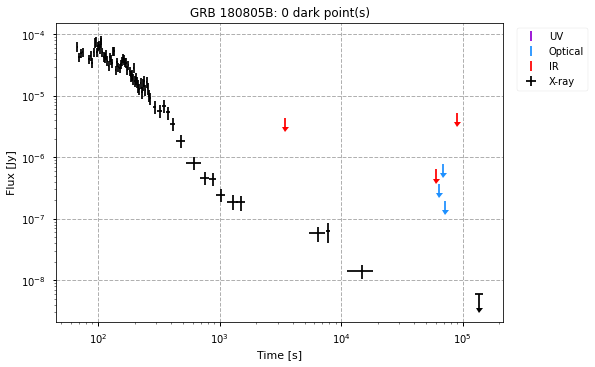

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
317,180727A,NaN,Magellan-Clay,LDSS3,i,7606.23,143424.0,24.2,3-sigma,Rastinejad,0.02,0.033035,"24.2 (+inf, -0.0)","7.820601527779771e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


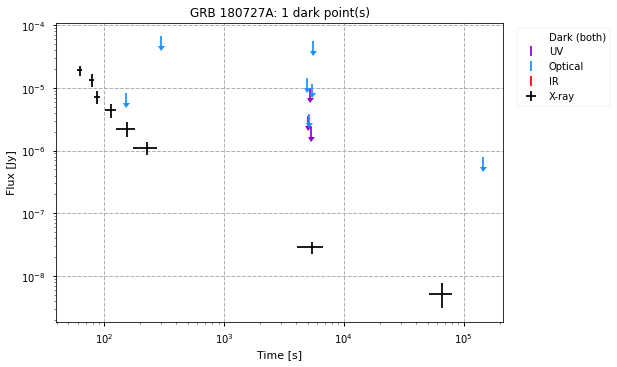

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
557,180418A,826428,Johnson,RATIR,r,6149.31,85608.0,23.63,0.22,GCN 22664,0.02,0.045928,23.63 ± 0.22,1.3378189033322842e-06 ± 2.7107888402659333e-07
558,180418A,826428,Johnson,RATIR,i,7531.29,85608.0,23.14,0.16,GCN 22664,0.02,0.033566,23.14 ± 0.16,2.0770766450139916e-06 ± 3.060893260681794e-07
559,180418A,826428,Gemini North,GMOS,r,6224.52,86400.0,23.86,0.13,2021ApJ...912...95R,0.02,0.045192,23.86 ± 0.13,1.0816905366730786e-06 ± 1.2951559425876032e-07
560,180418A,826428,Gemini North,GMOS,i,7713.83,96768.0,23.85,0.08,2021ApJ...912...95R,0.02,0.032293,23.85 ± 0.08,1.078806072312872e-06 ± 7.948936897085041e-08
561,180418A,826428,Gemini North,GMOS,z,9571.59,98496.0,23.37,0.29,2021ApJ...912...95R,0.02,0.022326,23.37 ± 0.29,1.6632461512941445e-06 ± 4.442528320981555e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


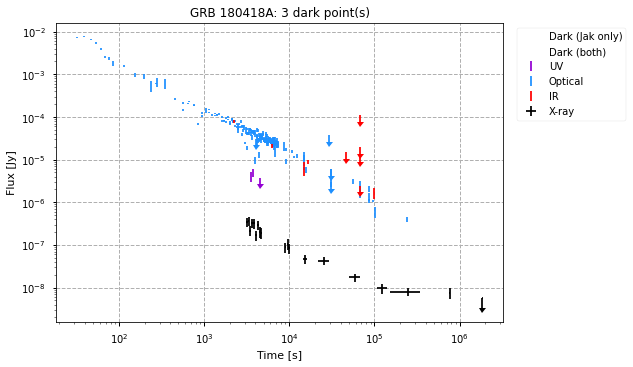

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
577,180402A,821103,Johnson,RATIR,r,6149.31,3222.0,23.3,3-sigma,GCN 22582,0.77,1.768216,"23.3 (+inf, -0.0)","8.857533477261686e-06 (+0.0, -inf)"
578,180402A,821103,Johnson,RATIR,i,7531.29,3222.0,23.3,3-sigma,GCN 22582,0.77,1.292279,"23.3 (+inf, -0.0)","5.713967703558705e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


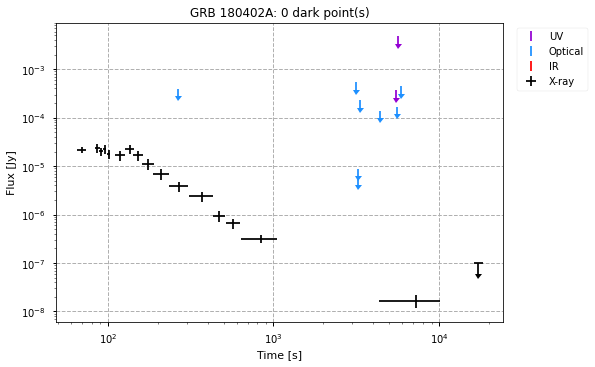

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


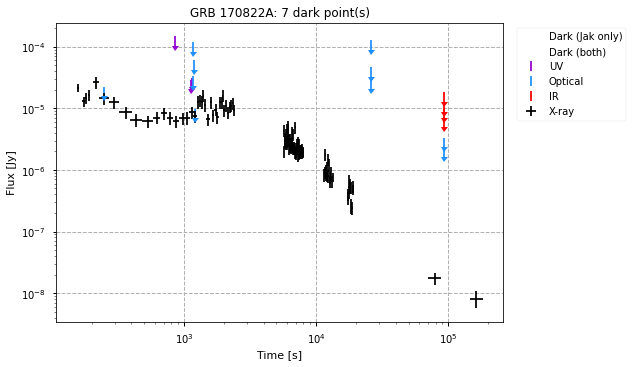

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


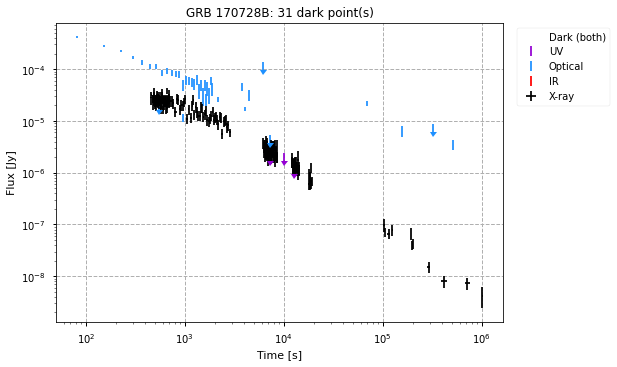

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
734,170428A,NaN,MMT,MMTCam,i,7591.2,265248.0,23.7,3-sigma,Rastinejad,0.06,0.099424,"23.7 (+inf, -0.0)","1.3176369133191583e-06 (+0.0, -inf)"
735,170428A,NaN,MMT,MMTCam,i,7591.2,352512.0,24.4,3-sigma,Rastinejad,0.06,0.099424,"24.4 (+inf, -0.0)","6.915056820103782e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


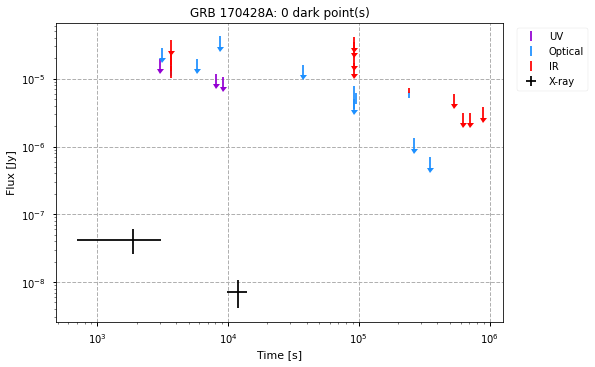

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
748,170127B,NaN,NOT,ALFSOC,r,6330.81,16416.0,23.4,3-sigma,Rastinejad,0.02,0.044047,"23.4 (+inf, -0.0)","1.6506123351826636e-06 (+0.0, -inf)"
749,170127B,735331,NOT,ALFOSC,r,6141.12,17028.0,23.5,?,GCN 20549,0.02,0.046046,"23.5 (+inf, -0.0)","1.5081501078292918e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


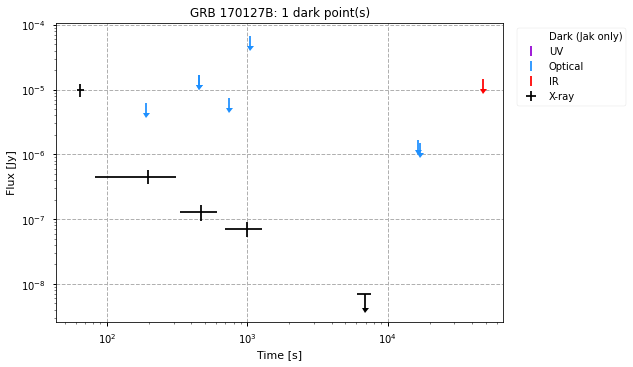

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
767,161104A,720568,Swift,UVOT,UVM2,2245.78,4879.0,23.39,3-sigma,GCN 20130,0.02,0.155467,"23.39 (+inf, -0.0)","1.8459202303851659e-06 (+0.0, -inf)"
770,161104A,720568,Gemini South,GMOS,r,6244.66,61200.0,24.60,NaN,GCN 20137,0.02,0.044971,"24.6 (+nan, -nan)","5.470345724447429e-07 (+nan, -nan)"
771,161104A,720568,La Silla,GROND,r',6097.98,64800.0,24.10,0.1,GCN 20132,0.02,0.046668,24.1 ± 0.1,8.683471997142399e-07 ± 7.99777327042053e-08


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


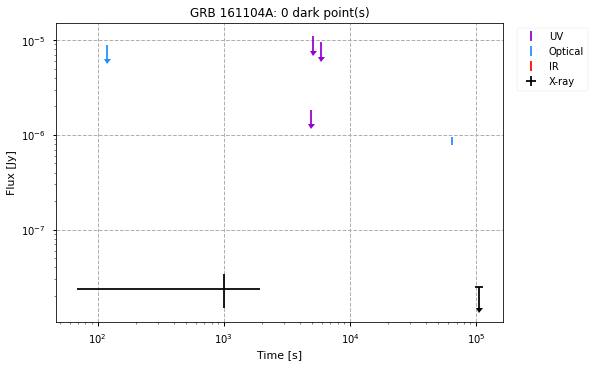

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


KeyboardInterrupt: 

In [54]:
for grb in all_optical[(all_optical["Magnitude"]>=23) & (all_optical["Time (s)"]>=1000) & (all_optical["GRB"].isin(xrt_data["GRB"]))]["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]
    of_interest = subset[(subset["Magnitude"]>=23) & (subset["Time (s)"]>=1000) & ~(subset["Time (s)"].isin(results.loc[results["GRB"]==grb,"t_o"]))]
    display(of_interest)
    display(results[(results["GRB"]==grb) & results["t_o"].isin(of_interest["Time (s)"])])

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
                marker="o",markersize=8,mfc="none",mec="slateblue",
                linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
                marker="o",markersize=8,mfc="none",mec="goldenrod",
                linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
                marker="o",markersize=8,mfc="none",mec="seagreen",
                linestyle="",label="Dark (both)")
        
    ax.plot(of_interest["Time (s)"],[flux.value for flux in of_interest["Flux (Jy)"]],"s",mec="green",mfc="none",ms=12)
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    plt.show()

## Population statistics

### Spectral index distributions

In [9]:
notvalid = lambda x : any((np.isinf(x), pd.isna(x)))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
oxlolims = [notvalid(v.plus) for v in darkest_times[B_ox_name]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times["B_x"]]

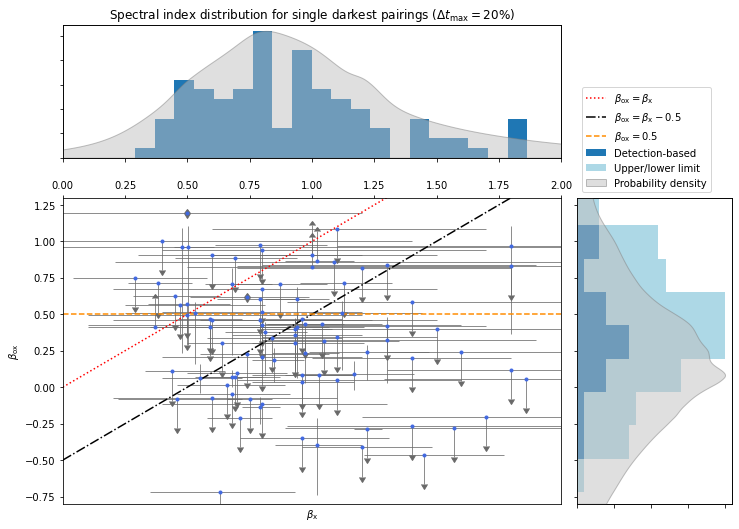

In [12]:
fig = plt.figure(figsize=(12,12))
grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], xticklabels=[], yticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[], yticklabels=[])

x = np.linspace(0,2,500)
y = np.linspace(-.8,1.3,500)
X,Y = np.meshgrid(x,y)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],
                 uplims=oxuplims,lolims=oxlolims,
                 linestyle="",marker=".",mfc="royalblue",mec="royalblue",
                 ecolor="dimgrey",elinewidth=0.75,capthick=1)
ax_main.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.xaxis.set_ticks_position("top")

# kde = stats.gaussian_kde(pd.Series(b_x)[pd.notna(b_x)])
# density = kde.evaluate(x)
ax_kde_x = ax_top.twinx()
valid_bx = [entry for entry in darkest_times["B_x"] if pd.notna(entry.value)]
ax_kde_x.fill_between(x,np.sum([bx.pdf(x) for bx in valid_bx],axis=0),facecolor="silver",edgecolor="grey",alpha=.5)
ax_kde_x.set_ylim(0,)#90)
ax_kde_x.set_yticks([])
ax_top.hist(b_x,23,orientation='vertical', color="C0")
# ax_top.set_yticks([])
ax_top.set_xlim(ax_main.get_xlim())

# kde = stats.gaussian_kde(pd.Series(b_ox)[pd.notna(b_x)])
# density = kde.evaluate(y)
ax_kde_y = ax_right.twiny()
valid_box = []
for i,row in darkest_times.iterrows():
    if np.isfinite(row[B_ox_name].minus):
        neg = row[B_ox_name].minus
    else:
        neg = 0.5
    if np.isfinite(row[B_ox_name].plus):
        pos = row[B_ox_name].plus
    else:
        pos = 0.5
    if np.isfinite(row[B_ox_name].value):
        valid_box.append(AsymmetricUncertainty(row[B_ox_name].value,pos,neg))
ax_kde_y.fill_betweenx(y,np.sum([box.pdf(y) for box in valid_box],axis=0),
                       facecolor="silver",edgecolor="grey",alpha=.5,label="Probability density")
ax_kde_y.set_xlim(0,)#70)
ax_kde_y.set_xticks([])
# ax_right.hist(, 18, orientation='horizontal', color="silver")
ax_right.hist([[b.value for b in darkest_times[B_ox_name] if all(np.isfinite(b.items()))],
               [b.value for b in darkest_times[B_ox_name] if any(np.isinf(b.items()))]],
              15, orientation='horizontal', stacked=True, color=["C0","lightblue"],
              label=["Detection-based","Upper/lower limit"])
# ax_right.set_xticks([])
ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xlim(0,)

# Z_x = np.sum([bx.pdf(X) for bx in valid_bx],axis=0)
# Z_x /= np.sum(Z_x)
# Z_ox = np.sum([box.pdf(Y) for box in valid_box],axis=0)
# Z_ox /= np.sum(Z_ox)
# ax_main.contourf(X,Y,np.sqrt(Z_x**2+Z_ox**2),30,cmap="Greys",vmax=4e-5,vmin=0)

fig.legend(loc="lower left",bbox_to_anchor=(0.72,0.68))

ax_top.set_title(r"Spectral index distribution for single darkest pairings ($\Delta t_\mathrm{max}="+"{:.0%}$%)".format(max_dt))

plt.savefig("./products/beta_distributions.png",dpi=300,bbox_inches="tight",facecolor="white")

plt.show()

In [24]:
from code.xrt import grb_list
sGRBs["N_H (intrinsic)"] = np.nan
sGRBs["N_H (intrinsic)"] = [AsymmetricUncertainty(nh) if pd.notna(nh) else np.nan for nh in sGRBs["N_H (intrinsic)"]]
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb,end=": ")
    if pd.notna(sGRBs.loc[i,"N_H (intrinsic)"]):
        print("already present")
        continue
    try:
        sGRBs.loc[i,"N_H (intrinsic)"],mode = get_columnDensity(grb,sGRBs)
        print("retrieved using",mode)
    except AssertionError:
        print("info doesn't exist")
    except ValueError:
        print("couldn't be parsed")
    except TypeError:
        print("trigger not found")

211227A: retrieved using PC
211221A: retrieved using PC
211207A: retrieved using PC
211106A: retrieved using PC
211023B: retrieved using PC
210919A: retrieved using PC
210726A: retrieved using PC
210725B: retrieved using PC
210708A: retrieved using PC
210704A: retrieved using PC
210618A: retrieved using PC
210413B: info doesn't exist
210410A: retrieved using PC
210323A: retrieved using PC
210217A: retrieved using PC
210119A: info doesn't exist
201221D: retrieved using PC
201221A: retrieved using PC
201015A: retrieved using PC
201006A: retrieved using PC
200917A: retrieved using PC
200907B: retrieved using PC
200826A: retrieved using PC
200729A: retrieved using PC
200716C: retrieved using PC
200623A: info doesn't exist
200522A: retrieved using PC
200517A: retrieved using PC
200512A: retrieved using PC
200411A: retrieved using PC
200409A: retrieved using PC
200219A: retrieved using PC
191031D: retrieved using PC
191031C: retrieved using PC
190719C: retrieved using PC
190627A: retrieved u

Text(0.5, 1.0, 'Hydrogen column densities by category')

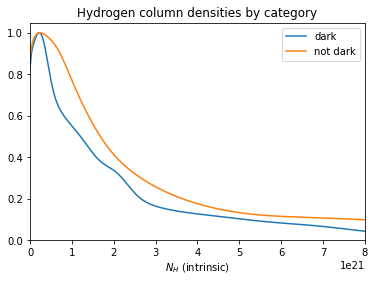

In [26]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# dark_nh = [v for v in dark_nh if v.value>0]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# notdark_nh = [v for v in notdark_nh if v.value>0]
max_x = 8e21
x = np.linspace(0,max_x,10000)
p_NH_dark = np.sum([nh.pdf(x) for nh in dark_nh],axis=0)
plt.plot(x,p_NH_dark/max(p_NH_dark),label="dark")
p_NH_notdark = np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)
plt.plot(x,p_NH_notdark/max(p_NH_notdark),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
# plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

Text(0.5, 1.0, 'Cumulative distributions of Hydrogen column density')

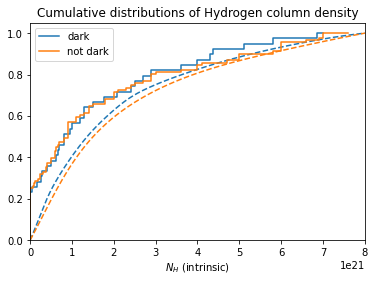

In [27]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark),color="tab:blue",linestyle="--")
plt.plot(x,np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark),color="tab:orange",linestyle="--")
x1 = np.sort([v.value for v  in dark_nh if v.value<max_x])
plt.step(x1, np.linspace(0, 1, len(x1)), where="pre", label="dark")
x2 = np.sort([v.value for v  in notdark_nh if v.value<max_x])
plt.step(x2, np.linspace(0, 1, len(x2)), where="pre", label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Cumulative distributions of Hydrogen column density")

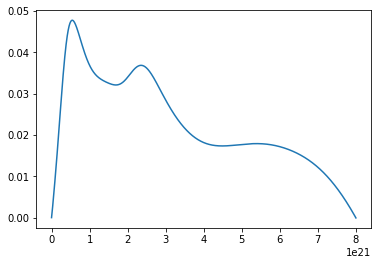

In [29]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark)-np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark))

In [28]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"],
               sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"])

KstestResult(statistic=0.12270531400966184, pvalue=0.6628289995125477)

In [30]:
comparison_table = pd.DataFrame(columns=["GRB","nu_o","F_o","nu_x","F_x","B_x","B_ox","N_H","Dark"])

for i,row in darkest_times.iterrows():
    grb = row["GRB"]
    b_ox = row[B_ox_name]
    b_x = row["B_x"]
    t_o = row["t_o"]
    flag = row["vdH_dark"] or row["Jak_dark"]
    try:
        n_h = sGRBs.loc[sGRBs["GRB"]==grb,"N_H (intrinsic)"].values[0]
    except IndexError:
        continue
#     n_h = (AsymmetricUncertainty(n_h)+1)/1e21 - 1e-21
    if np.isfinite(b_ox.minus):
        neg = b_ox.minus
    else:
        neg = 1
    if np.isfinite(b_ox.plus):
        pos = b_ox.plus
    else:
        pos = 1
    if np.isfinite(b_ox.value) and np.isfinite(b_x.value):
        comparison_table = comparison_table.append({"GRB":grb,"t_o":t_o,"nu_o":row["nu_o"],"F_o":row["F_o"],
                                                    "nu_x":row["nu_x"],"F_x":row["F_x"],"B_x":b_x,
                                                    "B_ox":AsymmetricUncertainty(b_ox.value,pos,neg),
                                                    "N_H":n_h,"Dark":flag},ignore_index=True)

comparison_table

,GRB,nu_o,F_o,nu_x,F_x,B_x,B_ox,N_H,Dark,t_o
0,210410A,8.514533e+14,"1.896435366219928e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.8540228932849895e-07 ± 7.008247560798059e-08,"0.45 (+0.18, -0.17)","0.6285722665573305 (+0.0887990824438643, -1.0)","4e+20 (+6e+20, -4e+20)",False,4861.5
1,210323A,7.715315e+14,"2.563308796098916e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3922226974815335e-05 ± 3.120230778601041e-06,0.7 ± 0.2,"0.0969379230400152 (+0.1010984371082567, -1.0)","1.76e+21 (+1.02e+21, -8.9e+20)",True,164.0
2,201006A,7.715315e+14,"0.0006668452230788575 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.063938154844078e-07 (+2.1232658339496232e-07...,"1.1 (+0.6, -0.5)","1.0878787981994062 (+0.1519811443663394, -1.0)","8e+21 (+7e+21, -5e+21)",False,163.0
3,200907B,7.715315e+14,"0.00011276729182535795 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.323644582195267e-06 ± 1.1261491867362315e-06,0.8 ± 0.4,"0.5179193728034049 (+0.13141213465665275, -1.0)","1.4e+21 (+2.9e+21, -1.4e+21)",False,158.5
4,200716C,4.477468e+14,0.0005347312552193564 ± 9.850113736208676e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,7.397240133933927e-07 ± 1.6826518892706168e-07,"0.5029999999999999 (+0.10400000000000001, -0.057)","0.9623306612157254 (+0.14205789935936575, -0.6...","0.0 (+2.2599999999999997e+20, -0.0)",False,10080.0
...,...,...,...,...,...,...,...,...,...,...
86,060427,4.735452e+14,"1.6030766349889176e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.2608960676787186e-08 ± 2.9669358710195424e-09,"1.13 (+0.19, -0.18)","0.7141240740155758 (+0.10995739412822128, -1.0)",9e+20 ± 5e+20,False,33300.0
87,060313,5.480667e+14,5.5e-05 ± 1.88e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,"1.571568979635134e-05 (+3.220475170818445e-06,...","0.8460000000000001 (+0.12, -0.087)","0.1886907057380031 (+0.08067170212970821, -0.1...","5e+19 (+3e+20, -5e+19)",True,162.0
88,060121,4.612192e+14,1.1e-06 ± 3.3e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6e-07 ± 1.4e-07,"1.17 (+0.24, -0.23)","0.08898986209278176 (+0.08876625765108984, -0....","8e+20 (+6e+20, -5e+20)",True,14040.0
89,051221A,4.758610e+14,1.56e-05 ± 1.2e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.54380389493966e-07 ± 5.822660323437297e-08,0.94 ± 0.13,"0.6071050733931347 (+0.0821552715693223, -0.42...","1.8e+21 (+1e+21, -9e+20)",False,12240.0


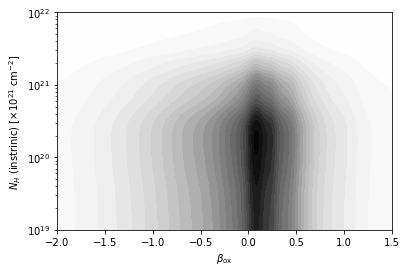

In [31]:
x,y = np.linspace(-2,1.5,250),np.linspace(0,10e21,150)
X,Y = np.meshgrid(x,y)
Z1 = np.sum([box.pdf(X) for box in comparison_table["B_ox"]],axis=0)
Z2 = np.sum([NH.pdf(Y) for NH in comparison_table["N_H"]],axis=0)
plt.contourf(X,Y,Z1*Z2,25,cmap="Greys")
plt.yscale("log")
plt.ylim(0.01e21,10e21)
plt.xlabel(r"$\beta_\mathrm{ox}$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
# plt.colorbar(label="Probability density")
plt.savefig("./products/B_ox-N_H.png",dpi=300,bbox_inches="tight",facecolor="white")

error term: $\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))$

error term: $\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}$

$$ \sigma_{m_\text{AB}} =  \sqrt{\left(\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))\right)^2 + \left(\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}\right)^2} $$

In [32]:
E_x = log_mean(0.3,10)
nu_x = E_x*241797944177033445
# nu_x = AsymmetricUncertainty(nu_x,10-nu_x,nu_x-0.3)
ABmag = lambda flux : -2.5*np.log10(flux/3631)

for i,row in comparison_table.iterrows():
    A_Bx = row["F_x"]/(nu_x**-row["B_x"])
    A_Bx05 = row["F_x"]/(nu_x**-(row["B_x"]-0.5))
    optflux_BoxBx = A_Bx*nu_o**-row["B_x"]
    optflux_BoxBx05 = A_Bx05*nu_o**-(row["B_x"]-0.5)
    
    obs_mag = ABmag(row["F_o"])
    
    m_plus = np.sqrt((row["B_x"].minus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                     (row["F_x"].plus*-2.5/np.log(10)/row["F_x"].value)**2)
    m_minus = np.sqrt((row["B_x"].plus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                      (row["F_x"].minus*-2.5/np.log(10)/row["F_x"].value)**2)
    
    unext_mag = AsymmetricUncertainty(ABmag(optflux_BoxBx),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x)"] = Av
    
    unext_mag = AsymmetricUncertainty(ABmag(optflux_BoxBx05),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x-0.5)"] = Av
    
    print(obs_mag,unext_mag,obs_mag-unext_mag)

20.7052205078125 (+0.0, -inf) 25.32017810862307 (+1.160948319706097, -1.2271302730460396) -4.614957600810573 (+1.2271302730460396, -inf)
20.37806330272135 (+0.0, -inf) 19.501201001595355 ± 1.3888131752443829 0.8768623011259962 (+1.3888131752443829, -inf)
16.84000301111537 (+0.0, -inf) 19.658669863000597 (+3.4338674235472233, -4.11319352553129) -2.818666851885226 (+4.11319352553129, -inf)
18.76960774549636 (+0.0, -inf) 20.001051387250442 ± 2.749242692838718 -1.2314436417540833 (+2.749242692838718, -inf)
17.079726698535083 ± 0.2 24.20429743640074 (+0.49013590994275835, -0.8103626095253392) -7.124570737865657 (+0.8346781169509102, -0.5293705792877195)
25.93221207003891 ± 0.04 29.96359977167536 (+1.9904292684674239, -inf) -4.031387701636447 (+inf, -1.9908311512460728)
21.520315008049064 (+0.0, -inf) 19.802968742298 (+1.5248910427630034, -1.5921777992444357) 1.7173462657510647 (+1.5921777992444357, -inf)
20.920315008049066 (+0.0, -inf) 15.001620219325424 (+1.7218069587367777, -2.40023302114

18.1433407079646 (+0.0, -inf) 18.973591854484955 (+5.180518760492887, -5.915198413876708) -0.8302511465203537 (+5.915198413876708, -inf)
13.773379674911661 ± 0.0 11.876617610645937 (+5.887973428354197, -7.561180616392066) 1.8967620642657241 (+7.561180616392066, -5.887973428354197)
23.083330255130335 (+0.0, -inf) 21.96928275289393 (+1.4866701827339117, -1.703182021303482) 1.1140475022364065 (+1.703182021303482, -inf)
21.01934476132459 (+0.0, -inf) 10.498825029057485 (+1.66033943654751, -2.2054747032524946) 10.520519732267104 (+2.2054747032524946, -inf)
21.160472512073593 (+0.0, -inf) 12.408336214073032 (+3.429060928581582, -4.109181701108478) 8.752136298000561 (+4.109181701108478, -inf)
24.06381949417331 ± 0.18937259385316207 26.943971410790326 (+2.9669768616434093, -inf) -2.8801519166170166 (+inf, -2.9730142409396647)
21.990399843514076 (+0.0, -inf) 27.35632207543127 (+0.8031648459370434, -0.9203024476997754) -5.365922231917192 (+0.9203024476997754, -inf)
23.017594582017846 (+0.0, -inf

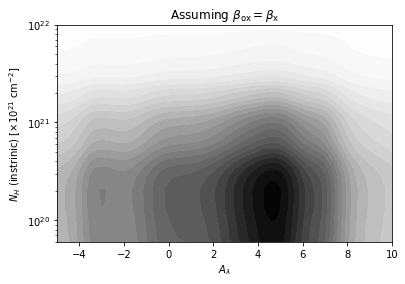

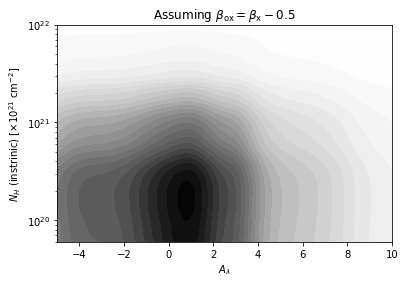

In [81]:
x,y = np.linspace(-5,10,250),np.linspace(0,10e21,150)
X,Y = np.meshgrid(x,y)
Z1 = np.sum([Av.pdf(X) for Av in comparison_table["Av (B_ox=B_x)"] if all(np.isfinite(Av.items()))],axis=0)
Z2 = np.sum([NH.pdf(Y) for NH in comparison_table["N_H"]],axis=0)
plt.contourf(X,Y,Z1*Z2,25,cmap="Greys")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.show()

Z1 = np.sum([Av.pdf(X) for Av in comparison_table["Av (B_ox=B_x-0.5)"] if all(np.isfinite(Av.items()))],axis=0)
Z2 = np.sum([NH.pdf(Y) for NH in comparison_table["N_H"]],axis=0)
plt.contourf(X,Y,Z1*Z2,25,cmap="Greys")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.show()

(-5.0, 10.0)

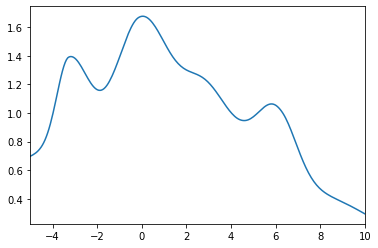

In [82]:
Z = np.sum([row["Av (B_ox=B_x)"].pdf(x) for i,row in comparison_table.iterrows() if (all(np.isfinite(row["Av (B_ox=B_x)"].items())) and row["t_o"]>1000)],axis=0)
plt.plot(x,Z)
plt.xlim(x.min(),x.max())

### Observation depth over time

150301A


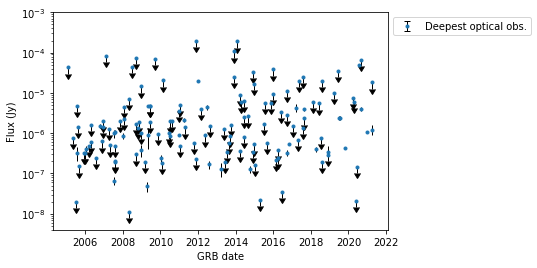

In [21]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if deepest_obs>1e-1:
        print(grb)
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest optical obs.",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylim(4e-9,1e-3)
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_flux_over_time.png",bbox_inches="tight",dpi=300)

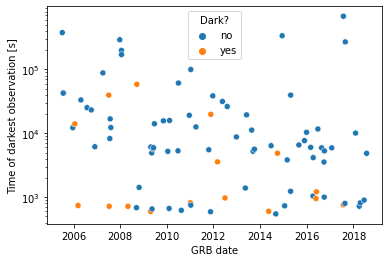

In [31]:
fig,ax = plt.subplots()
datestamps = []
darkest_t = []
cs = []

for grb,data in results.groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    data = data[data["t_o"]>500]
    try:
        datestamps.append(mm+"/"+dd+"/20"+yy)
        point = data.loc[data[B_ox_name]==data[B_ox_name].min(),:]
        darkest_t.append(float(point["t_o"]))
        if all(point["Jak_dark"]) or all(point["vdH_dark"]):
            cs.append("yes")
        else:
            cs.append("no")
    except:
        continue
    
datestamps = pd.to_datetime(datestamps)
sns.scatterplot(x="Date",y="Time",hue="Dark?",palette="tab10",
                data=pd.DataFrame(zip(datestamps,darkest_t,cs),
                                  columns=["Date","Time","Dark?"]))
plt.xlabel("GRB date")
plt.ylabel("Time of darkest observation [s]")
plt.yscale("log")
plt.savefig("./products/darkest_time_over_time.png",dpi=300,bbox_inches="tight")
plt.show()

5.882352941176471 ± 0.4687463956032126 short bursts per year
2.764705882352941 ± 0.3789440801977978 dark short bursts per year


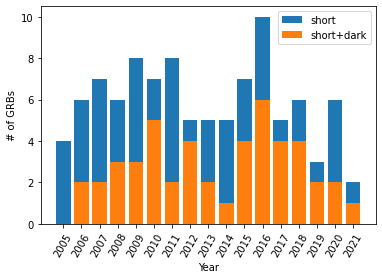

In [25]:
from code.utilities import addYear
addYear(sGRBs)
addYear(all_optical)
addYear(results)
addYear(dark)

dark_year_counts = {}
all_year_counts = {}

for year in range(2005,2022):
    sample = dark[dark["Year"]==year]
    dark_year_counts[str(year)] = len(sample["GRB"].unique())
        
for year in range(2005,2022):
    sample = results[results["Year"]==year]
    all_year_counts[str(year)] = len(sample["GRB"].unique())

plt.bar(all_year_counts.keys(),all_year_counts.values(),label="short")
plt.bar(dark_year_counts.keys(),dark_year_counts.values(),label="short+dark")
plt.xlabel("Year")
plt.ylabel("# of GRBs")
plt.legend()
plt.xticks(rotation=60)
print(np.mean(list(all_year_counts.values())),"±",stats.sem(list(all_year_counts.values())),"short bursts per year")
print(np.mean(list(dark_year_counts.values())),"±",stats.sem(list(dark_year_counts.values())),"dark short bursts per year")
plt.savefig("./products/numbers.png",dpi=300,bbox_inches="tight")
plt.show()

### Numbers

In [44]:
conf = np.zeros((5,5))
tables = (sGRBs,xrt_data,all_optical,results,dark)
names = ["main","xray","optical","matched","dark"]
for grb in sGRBs["GRB"].tolist():
    for i in range(5):
        for j in range(5):
            if i<j:
                conf[i,j] = np.nan
            elif grb in tables[i].GRB.tolist() and grb in tables[j].GRB.tolist():
                conf[i,j] += 1
conf 

array([[207.,  nan,  nan,  nan,  nan],
       [170., 170.,  nan,  nan,  nan],
       [156., 133., 156.,  nan,  nan],
       [ 93.,  93.,  93.,  93.,  nan],
       [ 45.,  45.,  45.,  45.,  45.]])

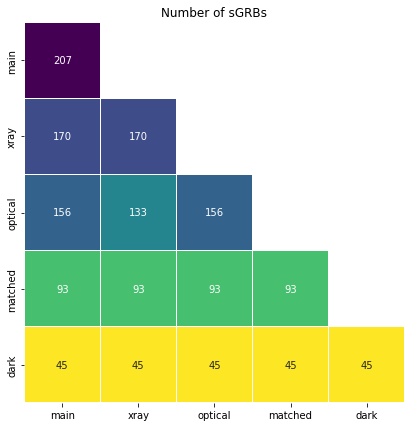

In [45]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=conf,annot=True,fmt="g",
            cmap="viridis_r",cbar=False,
            xticklabels=names,
            yticklabels=names,
            square=True,linewidths=0.1,ax=ax)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
plt.title("Number of sGRBs")
plt.show()

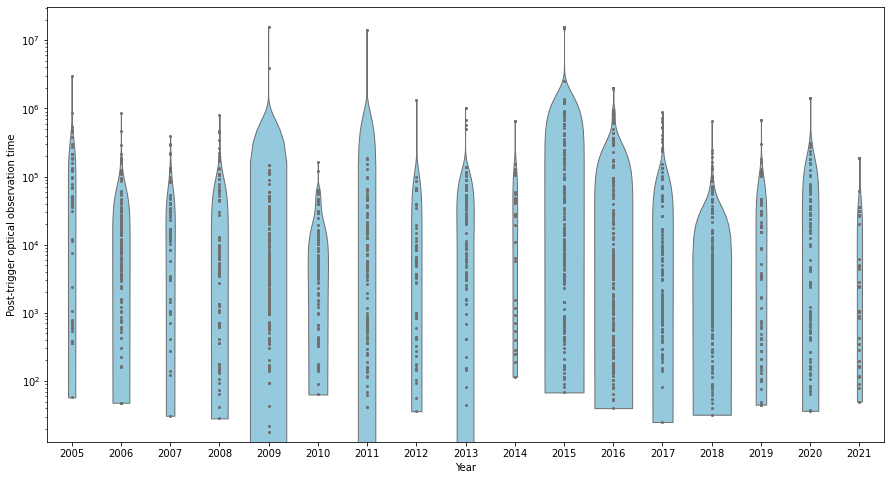

In [46]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="Time (s)",data=all_optical,color="skyblue",linewidth=1,
               scale="count",cut=0,bw=0.5,inner="point",ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
# plt.ylim(10,1e6)

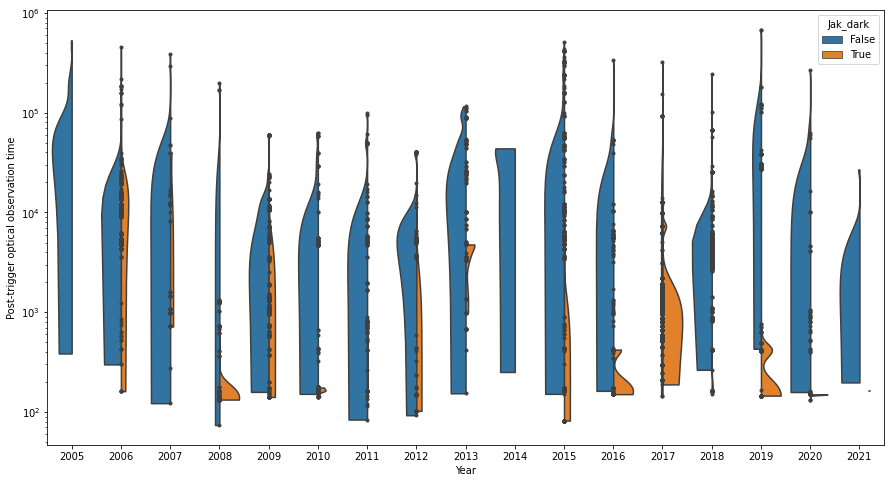

In [47]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="t_o",data=results[(results["t_o"]<1e6) & (results["Year"]>2004)],
               scale="count",inner="point",cut=0,hue="Jak_dark",split=True,ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
#plt.ylim(1,1e5)

## Optical spectra

In [48]:
for grb,data in results.groupby("GRB"):
    done = []
    for t_o in data["t_o"].unique():
        tmatch = data[np.abs(data["t_o"]-t_o)/t_o < 0.1].copy()
        for to,obs in tmatch.groupby("t_o"):
            tmatch.drop(tmatch[tmatch["dt%"]!=tmatch["dt%"].min()].index,axis=0,inplace=True)
        if t_o not in done and len(tmatch["nu_o"].unique()) > 2:
                print(grb,t_o)
                display(tmatch)
                done += tmatch["t_o"].unique().tolist()

060121 9000.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
3490,060121,9720.0,0.116364,4.863784e+14,"3.7239072180869405e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,6.1e-07 ± 1.4e-07,"0.267686061213581 (+0.047178000459071674, -inf)",1.0,"0.267686061213581 (+0.06716507221051132, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3491,060121,9720.0,0.116364,4.863784e+14,"3.7239072180869405e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.2e-07 ± 9.5e-08,"0.32290868251296584 (+0.051776441775912944, -inf)",1.0,"0.32290868251296584 (+0.07047115098181338, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3492,060121,9720.0,0.116364,4.863784e+14,"3.7239072180869405e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.5000000000000003e-07 ± 1.0000000000000001e-07,"0.3126998832925931 (+0.05044523493433717, -inf)",1.0,"0.3126998832925931 (+0.06949895628933937, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3493,060121,9720.0,0.116364,4.863784e+14,"3.7239072180869405e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.6999999999999995e-07 ± 1.1e-07,"0.3062654391637937 (+0.05102151973561949, -inf)",1.0,"0.3062654391637937 (+0.06991837150462847, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3494,060121,9720.0,0.116364,4.863784e+14,"3.7239072180869405e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.4000000000000003e-07 ± 8.7e-07,"0.3541758564136121 (+0.38109756095278813, -inf)",1.0,"0.3541758564136121 (+0.38408428002443823, -inf)","1.17 (+0.24, -0.23)",False,False,2006
3500,060121,9720.0,0.116364,3.916501e+14,"4.873884834658412e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,6.1e-07 ± 1.4e-07,"0.2979568022930262 (+0.04827276257720508, -inf)",1.0,"0.2979568022930262 (+0.06793852224299735, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3501,060121,9720.0,0.116364,3.916501e+14,"4.873884834658412e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.2e-07 ± 9.5e-08,"0.3514643591309044 (+0.05279647207891878, -inf)",1.0,"0.3514643591309044 (+0.07122394724885081, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3502,060121,9720.0,0.116364,3.916501e+14,"4.873884834658412e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.5000000000000003e-07 ± 1.0000000000000001e-07,"0.34157261745552936 (+0.05152242094920476, -inf)",1.0,"0.34157261745552936 (+0.07028472848488558, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3503,060121,9720.0,0.116364,3.916501e+14,"4.873884834658412e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.6999999999999995e-07 ± 1.1e-07,"0.33533800966544747 (+0.0520203766243385, -inf)",1.0,"0.33533800966544747 (+0.07065056816378093, -inf)","1.17 (+0.24, -0.23)",True,True,2006
3504,060121,9720.0,0.116364,3.916501e+14,"4.873884834658412e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.4000000000000003e-07 ± 8.7e-07,"0.3817604596288953 (+0.36964776128852256, -inf)",1.0,"0.3817604596288953 (+0.37272624085693723, -inf)","1.17 (+0.24, -0.23)",False,False,2006


080503 620.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
3168,080503,620.0,0.123748,6.361576e+14,"0.00013164354645135812 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.0110433739701649e-07 ± 2.297938039451e-08,"1.1050866413669602 (+0.14467013193440337, -inf)",8.0,"1.1050866413669602 (+0.43039424861514924, -inf)","1.4500000000000002 (+0.32, -0.24)",False,False,2008
3169,080503,620.0,0.123748,4.626870e+14,"8.539105490522088e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.0110433739701649e-07 ± 2.297938039451e-08,"0.9898254392685115 (+0.12432396480109532, -inf)",8.0,"0.9898254392685115 (+0.42398845549253483, -inf)","1.4500000000000002 (+0.32, -0.24)",False,False,2008
3170,080503,620.0,0.123748,3.821188e+14,"0.00022789739450369243 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.0110433739701649e-07 ± 2.297938039451e-08,"1.103017708565408 (+0.13389709922806223, -inf)",8.0,"1.103017708565408 (+0.4268936581266706, -inf)","1.4500000000000002 (+0.32, -0.24)",False,False,2008


080913 180.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
3019,080913,180.0,0.004001,4.916258e+14,"2.121749687386341e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.903896944943868e-06 ± 4.415637365634573e-07,"0.01605618847209473 (+0.033966781132171324, -inf)",1.2,"0.01605618847209473 (+0.03403045409397591, -inf)","0.6599999999999999 (+0.23, -0.2)",True,False,2008
3020,080913,180.0,0.004001,3.942179e+14,"2.472131557899378e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.903896944943868e-06 ± 4.415637365634573e-07,"0.03748108498254906 (+0.03313499678972337, -inf)",1.2,"0.03748108498254906 (+0.03320026502328483, -inf)","0.6599999999999999 (+0.23, -0.2)",True,False,2008
3021,080913,180.0,0.004001,3.357390e+14,4.219450020502084e-06 ± 0.0,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.903896944943868e-06 ± 4.415637365634573e-07,"0.11163150427182805 (+0.03460854883856727, -0....",1.2,"0.11163150427182805 (+0.034671043221582876, -0...","0.6599999999999999 (+0.23, -0.2)",True,False,2008


080913 360.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
3022,080913,360.0,0.090916,2.455797e+14,"0.0005394043662051895 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.0871714979756532e-06 ± 2.577277212404609e-07,"0.8340860037015736 (+0.09786142192508118, -inf)",1.2,"0.8340860037015736 (+0.10785842933373392, -inf)","0.6599999999999999 (+0.23, -0.2)",False,False,2008
3023,080913,360.0,0.090916,1.838814e+14,"0.00048688466512590166 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.0871714979756532e-06 ± 2.577277212404609e-07,"0.7896194722319819 (+0.08970857648510752, -inf)",1.2,"0.7896194722319819 (+0.10051970738181493, -inf)","0.6599999999999999 (+0.23, -0.2)",False,False,2008
3024,080913,360.0,0.090916,1.369818e+14,"0.0017573716758739568 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.0871714979756532e-06 ± 2.577277212404609e-07,"0.9205862265650239 (+0.09922308685231154, -inf)",1.2,"0.9205862265650239 (+0.10909538872767571, -inf)","0.6599999999999999 (+0.23, -0.2)",False,False,2008


080913 720.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
3028,080913,720.0,0.087132,6.655414e+14,"1.7379058652234989e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.26489000672688745 (+0.04983506698980007, -inf)",1.2,"0.26489000672688745 (+0.06617518208200589, -inf)","0.6599999999999999 (+0.23, -0.2)",True,False,2008
3030,080913,720.0,0.087132,4.916258e+14,"1.7379058652234989e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.2529994851385232 (+0.04661666694478352, -inf)",1.2,"0.2529994851385232 (+0.063786632288824, -inf)","0.6599999999999999 (+0.23, -0.2)",True,False,2008
3032,080913,720.0,0.087132,3.942179e+14,"2.291006117807585e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.284634977772599 (+0.047718095625235796, -inf)",1.2,"0.284634977772599 (+0.06459595553754059, -inf)","0.6599999999999999 (+0.23, -0.2)",True,False,2008
3034,080913,720.0,0.087132,3.357390e+14,3.5647267811055704e-06 ± 4.9248520480622e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.3402391403389642 (+0.05494124585817459, -0.2...",1.2,"0.3402391403389642 (+0.07010107929381086, -0.2...","0.6599999999999999 (+0.23, -0.2)",True,False,2008
3036,080913,720.0,0.087132,2.447983e+14,1.5849889868640448e-05 ± 8.758972832910923e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.5262222241705741 (+0.06682880308734643, -0.3...",1.2,"0.5262222241705741 (+0.07976032687869387, -0.3...","0.6599999999999999 (+0.23, -0.2)",False,False,2008
3038,080913,720.0,0.087132,1.835816e+14,1.9589630703524253e-05 ± 1.6238444988669629e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.5340339423580948 (+0.06556209647062891, -0.3...",1.2,"0.5340339423580948 (+0.07870202866084726, -0.3...","0.6599999999999999 (+0.23, -0.2)",False,False,2008
3040,080913,720.0,0.087132,1.391121e+14,2.2081381896430282e-05 ± 4.2709179061440324e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,3.1524048793554437e-07 ± 7.501152180985261e-08,"0.5304888899837922 (+0.06664551984915405, -0.3...",1.2,"0.5304888899837922 (+0.07960682218046868, -0.3...","0.6599999999999999 (+0.23, -0.2)",False,False,2008


090423 13716.864000000001


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2986,090423,13716.864,0.124212,6.361576e+14,"2.7524086323556257e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.123057848924482e-07 ± 2.9678819485253674e-08,"0.847739734882957 (+0.11542435421285616, -inf)",1.41,"0.847739734882957 (+0.13587887920961053, -inf)",0.71 ± 0.13,False,False,2009
2993,090423,13716.864,0.124212,4.626870e+14,"3.204197770117918e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.123057848924482e-07 ± 2.9678819485253674e-08,"0.830417564370326 (+0.1080604544762866, -inf)",1.41,"0.830417564370326 (+0.12968172612757223, -inf)",0.71 ± 0.13,False,False,2009
3000,090423,13716.864,0.124212,3.821188e+14,"6.010115310236266e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.123057848924482e-07 ± 2.9678819485253674e-08,"0.8975812153941012 (+0.1125469306595297, -inf)",1.41,"0.8975812153941012 (+0.13344324587886056, -inf)",0.71 ± 0.13,False,False,2009


090426 376.704


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2817,090426,376.704,0.088658,6.361576e+14,0.0002900574494604127 ± 2.137222269566145e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.9067051798127283e-06 ± 4.2987684486984494e-07,"0.7742559346880049 (+0.10515512911583419, -0.5...",0.94,"0.7742559346880049 (+0.11072563169201569, -0.5...","0.96 (+0.16, -0.15)",False,False,2009
2819,090426,376.704,0.088658,4.626870e+14,0.0004541036146342407 ± 3.34595908394085e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.9067051798127283e-06 ± 4.2987684486984494e-07,"0.8038862677674623 (+0.10362029645527401, -0.5...",0.94,"0.8038862677674623 (+0.10926907234760906, -0.5...","0.96 (+0.16, -0.15)",False,False,2009
2821,090426,376.704,0.088658,3.821188e+14,0.0006495271153159908 ± 5.9823658128881e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.9067051798127283e-06 ± 4.2987684486984494e-07,"0.8330486864883209 (+0.10433901938502343, -0.5...",0.94,"0.8330486864883209 (+0.1099508767607446, -0.57...","0.96 (+0.16, -0.15)",False,False,2009


090426 964.224


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2846,090426,1035.072,0.014465,6.361576e+14,6.523550426659195e-05 ± 1.8626077157617312e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.478940951090471e-07 ± 1.262003838027628e-07,"0.7365000297957721 (+0.10950500635973141, -0.5...",0.94,"0.7365000297957721 (+0.109661844571703, -0.544...","0.96 (+0.16, -0.15)",False,False,2009
2849,090426,1035.072,0.014465,4.626870e+14,8.187568733739936e-05 ± 2.0360779611307614e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.478940951090471e-07 ± 1.262003838027628e-07,"0.7354277515246661 (+0.10221589606917719, -0.5...",0.94,"0.7354277515246661 (+0.10238390081574526, -0.5...","0.96 (+0.16, -0.15)",False,False,2009
2852,090426,1035.072,0.014465,3.821188e+14,0.00017889462245997354 ± 4.283968945288582e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.478940951090471e-07 ± 1.262003838027628e-07,"0.8269913854324535 (+0.1085776081541656, -0.56...",0.94,"0.8269913854324535 (+0.10873578403406607, -0.5...","0.96 (+0.16, -0.15)",False,False,2009


090426 5040.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2899,090426,5480.352,0.020503,6.361576e+14,2.6211026155413417e-05 ± 9.17367395082486e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3680813654310403e-07 ± 3.642941631008612e-08,"0.8097973394603906 (+0.12340032416090582, -0.5...",0.94,"0.8097973394603906 (+0.1236781658597461, -0.59...","0.96 (+0.16, -0.15)",False,False,2009
2902,090426,5480.352,0.020503,4.626870e+14,4.2968971527745086e-05 ± 8.706694770494286e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3680813654310403e-07 ± 3.642941631008612e-08,"0.8445297429445892 (+0.11369727557595544, -0.5...",0.94,"0.8445297429445892 (+0.11399876833022794, -0.5...","0.96 (+0.16, -0.15)",False,False,2009
2905,090426,5480.352,0.020503,3.821188e+14,6.14606693826714e-05 ± 1.981257895763646e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3680813654310403e-07 ± 3.642941631008612e-08,"0.8725812324595142 (+0.11910155347210366, -0.5...",0.94,"0.8725812324595142 (+0.11938939964202264, -0.5...","0.96 (+0.16, -0.15)",False,False,2009


090426 5760.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2899,090426,5480.352,0.020503,6.361576e+14,2.6211026155413417e-05 ± 9.17367395082486e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3680813654310403e-07 ± 3.642941631008612e-08,"0.8097973394603906 (+0.12340032416090582, -0.5...",0.94,"0.8097973394603906 (+0.1236781658597461, -0.59...","0.96 (+0.16, -0.15)",False,False,2009
2902,090426,5480.352,0.020503,4.626870e+14,4.2968971527745086e-05 ± 8.706694770494286e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3680813654310403e-07 ± 3.642941631008612e-08,"0.8445297429445892 (+0.11369727557595544, -0.5...",0.94,"0.8445297429445892 (+0.11399876833022794, -0.5...","0.96 (+0.16, -0.15)",False,False,2009
2905,090426,5480.352,0.020503,3.821188e+14,6.14606693826714e-05 ± 1.981257895763646e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3680813654310403e-07 ± 3.642941631008612e-08,"0.8725812324595142 (+0.11910155347210366, -0.5...",0.94,"0.8725812324595142 (+0.11938939964202264, -0.5...","0.96 (+0.16, -0.15)",False,False,2009


090426 7200.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2914,090426,7200.0,0.04132,3.757363e+14,7.949221981227501e-05 ± 4.392902408370009e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,8.770752409196573e-08 ± 2.3297121213128358e-08,"0.9705157538514715 (+0.12069646347029996, -0.6...",0.94,"0.9705157538514715 (+0.12182302526321022, -0.6...","0.96 (+0.16, -0.15)",False,False,2009
2918,090426,7200.0,0.04132,4.673887e+14,2.893310868754059e-05 ± 5.329675580632599e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,8.770752409196573e-08 ± 2.3297121213128358e-08,"0.8530055786032785 (+0.11085890313044564, -0.6...",0.94,"0.8530055786032785 (+0.1120843860371677, -0.60...","0.96 (+0.16, -0.15)",False,False,2009
2922,090426,7200.0,0.04132,5.505123e+14,1.5630692105522657e-05 ± 5.75855978165699e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,8.770752409196573e-08 ± 2.3297121213128358e-08,"0.7812388003580433 (+0.10538116392544472, -0.5...",0.94,"0.7812388003580433 (+0.10666959688835781, -0.5...","0.96 (+0.16, -0.15)",False,False,2009
2926,090426,7200.0,0.04132,4.163784e+14,2.46e-05 ± 3.9e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,8.770752409196573e-08 ± 2.3297121213128358e-08,"0.815279884549556 (+0.10724219591114781, -0.56...",0.94,"0.815279884549556 (+0.10850853318466853, -0.56...","0.96 (+0.16, -0.15)",False,False,2009


110106A 8317.5


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2582,110106A,8584.704,0.131444,6.361576e+14,"3.610102623089009e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.0613023643797727e-08 ± 1.2711438854735009e-08,"1.04626862051361 (+0.1417520858924979, -inf)",1.11,"1.04626862051361 (+0.15374585570132585, -inf)",1.5 ± 0.5,False,False,2011
2583,110106A,8584.704,0.131444,4.626870e+14,"4.0324665023164604e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.0613023643797727e-08 ± 1.2711438854735009e-08,"1.013589174375667 (+0.13139777819425336, -inf)",1.11,"1.013589174375667 (+0.14425501864699544, -inf)",1.5 ± 0.5,False,False,2011
2584,110106A,8584.704,0.131444,3.821188e+14,"8.144767535214837e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.0613023643797727e-08 ± 1.2711438854735009e-08,"1.0863205719340059 (+0.13588772208844457, -inf)",1.11,"1.0863205719340059 (+0.14835635242498094, -inf)",1.5 ± 0.5,False,False,2011


120804A 40249.439999999995


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2419,120804A,40249.44,0.043178,6.361576e+14,"8.022147818660016e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.8369754505165708e-08 ± 4.956214647375757e-09,"1.2915571486591046 (+0.16968414926932468, -inf)",1.095,"1.2915571486591046 (+0.17087078001922076, -inf)","0.96 (+0.21, -0.2)",False,False,2012
2421,120804A,40249.44,0.043178,4.626870e+14,"6.87078586326926e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.8369754505165708e-08 ± 4.956214647375757e-09,"1.2083984399538599 (+0.15197536585438406, -inf)",1.095,"1.2083984399538599 (+0.1532991349541685, -inf)","0.96 (+0.21, -0.2)",False,False,2012
2423,120804A,40249.44,0.043178,3.821188e+14,"0.00011603611367984676 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.8369754505165708e-08 ± 4.956214647375757e-09,"1.25023728503006 (+0.15259899622738995, -inf)",1.095,"1.25023728503006 (+0.15391740187753122, -inf)","0.96 (+0.21, -0.2)",False,False,2012


121226A 3621.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2330,121226A,3743.712,0.147952,6.361576e+14,"3.57096118716993e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,9.076190564751554e-08 ± 2.680644949568071e-08,"0.9206772890969991 (+0.12581455551490522, -inf)",1.04,"0.9206772890969991 (+0.14040353908743852, -inf)",1.4 ± 0.4,False,False,2012
2331,121226A,3743.712,0.147952,4.626870e+14,"3.366124705196544e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,9.076190564751554e-08 ± 2.680644949568071e-08,"0.8689430854563214 (+0.11409591197826185, -inf)",1.04,"0.8689430854563214 (+0.1300066480569974, -inf)",1.4 ± 0.4,False,False,2012
2332,121226A,3743.712,0.147952,3.821188e+14,"6.231557414690432e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,9.076190564751554e-08 ± 2.680644949568071e-08,"0.9331795411056737 (+0.11803046160879098, -inf)",1.04,"0.9331795411056737 (+0.13347299830470952, -inf)",1.4 ± 0.4,False,False,2012


130603B 43920.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2306,130603B,48222.0,0.003044,4.875221e+14,1.8467041630481676e-05 ± 5.102632172405707e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9929427727910082 (+0.12629745964193007, -0.7...",1.0,"0.9929427727910082 (+0.12630435934017228, -0.7...","0.97 (+0.14, -0.13)",False,False,2013
2307,130603B,48222.0,0.003044,3.980626e+14,2.3198105676394787e-05 ± 6.409873477940062e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9967923134119577 (+0.12305813134006764, -0.6...",1.0,"0.9967923134119577 (+0.12306521265262474, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2308,130603B,48222.0,0.003044,3.411380e+14,3.0929821070392294e-05 ± 1.4243708985131687e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.015606535995575 (+0.12260394563943981, -0.68...",1.0,"1.015606535995575 (+0.12261105318316584, -0.68...","0.97 (+0.14, -0.13)",False,False,2013
2309,130603B,48222.0,0.003044,2.947018e+14,3.909311382994146e-05 ± 1.8003044228708514e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.027401035754334 (+0.12142665308775755, -0.67...",1.0,"1.027401035754334 (+0.1214338295386464, -0.676...","0.97 (+0.14, -0.13)",False,False,2013
2310,130603B,48222.0,0.003044,2.411140e+14,3.782193109767061e-05 ± 2.090117153609863e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9953294612075222 (+0.11481140363912007, -0.6...",1.0,"0.9953294612075222 (+0.11481899355904215, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2311,130603B,48222.0,0.003044,1.860597e+14,5.543684432520371e-05 ± 3.063553232300295e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.0114406539775094 (+0.11261521113185216, -0.6...",1.0,"1.0114406539775094 (+0.11262294905834268, -0.6...","0.97 (+0.14, -0.13)",False,False,2013


130603B 51840.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2306,130603B,48222.0,0.003044,4.875221e+14,1.8467041630481676e-05 ± 5.102632172405707e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9929427727910082 (+0.12629745964193007, -0.7...",1.0,"0.9929427727910082 (+0.12630435934017228, -0.7...","0.97 (+0.14, -0.13)",False,False,2013
2307,130603B,48222.0,0.003044,3.980626e+14,2.3198105676394787e-05 ± 6.409873477940062e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9967923134119577 (+0.12305813134006764, -0.6...",1.0,"0.9967923134119577 (+0.12306521265262474, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2308,130603B,48222.0,0.003044,3.411380e+14,3.0929821070392294e-05 ± 1.4243708985131687e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.015606535995575 (+0.12260394563943981, -0.68...",1.0,"1.015606535995575 (+0.12261105318316584, -0.68...","0.97 (+0.14, -0.13)",False,False,2013
2309,130603B,48222.0,0.003044,2.947018e+14,3.909311382994146e-05 ± 1.8003044228708514e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.027401035754334 (+0.12142665308775755, -0.67...",1.0,"1.027401035754334 (+0.1214338295386464, -0.676...","0.97 (+0.14, -0.13)",False,False,2013
2310,130603B,48222.0,0.003044,2.411140e+14,3.782193109767061e-05 ± 2.090117153609863e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9953294612075222 (+0.11481140363912007, -0.6...",1.0,"0.9953294612075222 (+0.11481899355904215, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2311,130603B,48222.0,0.003044,1.860597e+14,5.543684432520371e-05 ± 3.063553232300295e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.0114406539775094 (+0.11261521113185216, -0.6...",1.0,"1.0114406539775094 (+0.11262294905834268, -0.6...","0.97 (+0.14, -0.13)",False,False,2013


130603B 52200.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2306,130603B,48222.0,0.003044,4.875221e+14,1.8467041630481676e-05 ± 5.102632172405707e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9929427727910082 (+0.12629745964193007, -0.7...",1.0,"0.9929427727910082 (+0.12630435934017228, -0.7...","0.97 (+0.14, -0.13)",False,False,2013
2307,130603B,48222.0,0.003044,3.980626e+14,2.3198105676394787e-05 ± 6.409873477940062e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9967923134119577 (+0.12305813134006764, -0.6...",1.0,"0.9967923134119577 (+0.12306521265262474, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2308,130603B,48222.0,0.003044,3.411380e+14,3.0929821070392294e-05 ± 1.4243708985131687e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.015606535995575 (+0.12260394563943981, -0.68...",1.0,"1.015606535995575 (+0.12261105318316584, -0.68...","0.97 (+0.14, -0.13)",False,False,2013
2309,130603B,48222.0,0.003044,2.947018e+14,3.909311382994146e-05 ± 1.8003044228708514e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.027401035754334 (+0.12142665308775755, -0.67...",1.0,"1.027401035754334 (+0.1214338295386464, -0.676...","0.97 (+0.14, -0.13)",False,False,2013
2310,130603B,48222.0,0.003044,2.411140e+14,3.782193109767061e-05 ± 2.090117153609863e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9953294612075222 (+0.11481140363912007, -0.6...",1.0,"0.9953294612075222 (+0.11481899355904215, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2311,130603B,48222.0,0.003044,1.860597e+14,5.543684432520371e-05 ± 3.063553232300295e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.0114406539775094 (+0.11261521113185216, -0.6...",1.0,"1.0114406539775094 (+0.11262294905834268, -0.6...","0.97 (+0.14, -0.13)",False,False,2013


130603B 52560.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2306,130603B,48222.0,0.003044,4.875221e+14,1.8467041630481676e-05 ± 5.102632172405707e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9929427727910082 (+0.12629745964193007, -0.7...",1.0,"0.9929427727910082 (+0.12630435934017228, -0.7...","0.97 (+0.14, -0.13)",False,False,2013
2307,130603B,48222.0,0.003044,3.980626e+14,2.3198105676394787e-05 ± 6.409873477940062e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9967923134119577 (+0.12305813134006764, -0.6...",1.0,"0.9967923134119577 (+0.12306521265262474, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2308,130603B,48222.0,0.003044,3.411380e+14,3.0929821070392294e-05 ± 1.4243708985131687e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.015606535995575 (+0.12260394563943981, -0.68...",1.0,"1.015606535995575 (+0.12261105318316584, -0.68...","0.97 (+0.14, -0.13)",False,False,2013
2309,130603B,48222.0,0.003044,2.947018e+14,3.909311382994146e-05 ± 1.8003044228708514e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.027401035754334 (+0.12142665308775755, -0.67...",1.0,"1.027401035754334 (+0.1214338295386464, -0.676...","0.97 (+0.14, -0.13)",False,False,2013
2310,130603B,48222.0,0.003044,2.411140e+14,3.782193109767061e-05 ± 2.090117153609863e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9953294612075222 (+0.11481140363912007, -0.6...",1.0,"0.9953294612075222 (+0.11481899355904215, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2311,130603B,48222.0,0.003044,1.860597e+14,5.543684432520371e-05 ± 3.063553232300295e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.0114406539775094 (+0.11261521113185216, -0.6...",1.0,"1.0114406539775094 (+0.11262294905834268, -0.6...","0.97 (+0.14, -0.13)",False,False,2013


130603B 52920.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2306,130603B,48222.0,0.003044,4.875221e+14,1.8467041630481676e-05 ± 5.102632172405707e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9929427727910082 (+0.12629745964193007, -0.7...",1.0,"0.9929427727910082 (+0.12630435934017228, -0.7...","0.97 (+0.14, -0.13)",False,False,2013
2307,130603B,48222.0,0.003044,3.980626e+14,2.3198105676394787e-05 ± 6.409873477940062e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9967923134119577 (+0.12305813134006764, -0.6...",1.0,"0.9967923134119577 (+0.12306521265262474, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2308,130603B,48222.0,0.003044,3.411380e+14,3.0929821070392294e-05 ± 1.4243708985131687e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.015606535995575 (+0.12260394563943981, -0.68...",1.0,"1.015606535995575 (+0.12261105318316584, -0.68...","0.97 (+0.14, -0.13)",False,False,2013
2309,130603B,48222.0,0.003044,2.947018e+14,3.909311382994146e-05 ± 1.8003044228708514e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.027401035754334 (+0.12142665308775755, -0.67...",1.0,"1.027401035754334 (+0.1214338295386464, -0.676...","0.97 (+0.14, -0.13)",False,False,2013
2310,130603B,48222.0,0.003044,2.411140e+14,3.782193109767061e-05 ± 2.090117153609863e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9953294612075222 (+0.11481140363912007, -0.6...",1.0,"0.9953294612075222 (+0.11481899355904215, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2311,130603B,48222.0,0.003044,1.860597e+14,5.543684432520371e-05 ± 3.063553232300295e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.0114406539775094 (+0.11261521113185216, -0.6...",1.0,"1.0114406539775094 (+0.11262294905834268, -0.6...","0.97 (+0.14, -0.13)",False,False,2013


130603B 53280.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2306,130603B,48222.0,0.003044,4.875221e+14,1.8467041630481676e-05 ± 5.102632172405707e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9929427727910082 (+0.12629745964193007, -0.7...",1.0,"0.9929427727910082 (+0.12630435934017228, -0.7...","0.97 (+0.14, -0.13)",False,False,2013
2307,130603B,48222.0,0.003044,3.980626e+14,2.3198105676394787e-05 ± 6.409873477940062e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9967923134119577 (+0.12305813134006764, -0.6...",1.0,"0.9967923134119577 (+0.12306521265262474, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2308,130603B,48222.0,0.003044,3.411380e+14,3.0929821070392294e-05 ± 1.4243708985131687e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.015606535995575 (+0.12260394563943981, -0.68...",1.0,"1.015606535995575 (+0.12261105318316584, -0.68...","0.97 (+0.14, -0.13)",False,False,2013
2309,130603B,48222.0,0.003044,2.947018e+14,3.909311382994146e-05 ± 1.8003044228708514e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.027401035754334 (+0.12142665308775755, -0.67...",1.0,"1.027401035754334 (+0.1214338295386464, -0.676...","0.97 (+0.14, -0.13)",False,False,2013
2310,130603B,48222.0,0.003044,2.411140e+14,3.782193109767061e-05 ± 2.090117153609863e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"0.9953294612075222 (+0.11481140363912007, -0.6...",1.0,"0.9953294612075222 (+0.11481899355904215, -0.6...","0.97 (+0.14, -0.13)",False,False,2013
2311,130603B,48222.0,0.003044,1.860597e+14,5.543684432520371e-05 ± 3.063553232300295e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.2546776018122463e-08 ± 5.2193438980126646e-09,"1.0114406539775094 (+0.11261521113185216, -0.6...",1.0,"1.0114406539775094 (+0.11262294905834268, -0.6...","0.97 (+0.14, -0.13)",False,False,2013


130912A 89280.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2232,130912A,89856.0,0.175668,4.875220e+14,"3.1421092304797613e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.0210587457260483e-09 (+2.1184929337295118e-1...,1.0283035393026794 ± inf,1.463,1.0283035393026794 ± inf,"0.44 (+0.21, -0.11)",False,False,2013
2233,130912A,89856.0,0.175668,3.980624e+14,"2.6791310634162193e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.0210587457260483e-09 (+2.1184929337295118e-1...,0.975438200435569 ± inf,1.463,0.975438200435569 ± inf,"0.44 (+0.21, -0.11)",False,False,2013
2234,130912A,89856.0,0.175668,2.411140e+14,"6.310598339633804e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.0210587457260483e-09 (+2.1184929337295118e-1...,1.0247301507735775 ± inf,1.463,1.0247301507735775 ± inf,"0.44 (+0.21, -0.11)",False,False,2013


131004A 10080.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2206,131004A,10080.0,0.106765,6.284957e+14,6e-06 ± 5.8e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.7207391325921417 (+0.09869380030764972, -0.5...",0.97,"0.7207391325921417 (+0.10754831142618532, -0.5...","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2207,131004A,10080.0,0.106765,4.819814e+14,9.6e-06 ± 9.300000000000001e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.7619230866559398 (+0.09951743909293699, -0.5...",0.97,"0.7619230866559398 (+0.10830463404247265, -0.5...","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2208,131004A,10080.0,0.106765,3.929128e+14,1.31e-05 ± 1.3e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.7841812637544955 (+0.09912251347310588, -0.5...",0.97,"0.7841812637544955 (+0.10794186281829474, -0.5...","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2209,131004A,10080.0,0.106765,3.283598e+14,1.4e-05 ± 1.4e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.7737914573085923 (+0.09552414224588819, -0.5...",0.97,"0.7737914573085923 (+0.10464719214231304, -0.5...","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2210,131004A,10080.0,0.106765,2.417681e+14,4.65e-05 ± 7.4e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.9029975352918039 (+0.10644184607012454, -0.5...",0.97,"0.9029975352918039 (+0.11469978058511528, -0.5...","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2211,131004A,10080.0,0.106765,1.946704e+14,3.4e-05 ± 6.9e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.8367016326428296 (+0.09813041963779483, -0.5...",0.97,"0.8367016326428296 (+0.10703154829183407, -0.5...","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2212,131004A,10080.0,0.106765,1.375195e+14,"4.73e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,5.533402987039364e-08 ± 1.20894719455795e-08,"0.8416085610066762 (+0.09088795978958712, -inf)",0.97,"0.8416085610066762 (+0.10043303393889437, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013


131004A 26280.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2213,131004A,26280.0,0.137647,4.804366e+14,"1.6000000000000001e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3461365204079787e-08 ± 3.668771224659887e-09,"0.7057022934550411 (+0.09506946565438838, -inf)",0.97,"0.7057022934550411 (+0.10949723213252095, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2214,131004A,26280.0,0.137647,3.893409e+14,"1.8999999999999998e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3461365204079787e-08 ± 3.668771224659887e-09,"0.7090663220232315 (+0.09256755710457222, -inf)",0.97,"0.7090663220232315 (+0.10733216280864039, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2215,131004A,26280.0,0.137647,3.414493e+14,"2.8999999999999998e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3461365204079787e-08 ± 3.668771224659887e-09,"0.7554371348152612 (+0.09577679476287533, -inf)",0.97,"0.7554371348152612 (+0.11011192015364271, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2216,131004A,26280.0,0.137647,2.991941e+14,"4.8e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3461365204079787e-08 ± 3.668771224659887e-09,"0.8112216320773077 (+0.0999006085665724, -inf)",0.97,"0.8112216320773077 (+0.11371707056042098, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2217,131004A,26280.0,0.137647,2.398340e+14,"3.6000000000000003e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3461365204079787e-08 ± 3.668771224659887e-09,"0.7486541103991339 (+0.09055630590672556, -inf)",0.97,"0.7486541103991339 (+0.10560248616554775, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013
2218,131004A,26280.0,0.137647,1.833593e+14,"3.6000000000000003e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.3461365204079787e-08 ± 3.668771224659887e-09,"0.7226623280122498 (+0.08487545141344487, -inf)",0.97,"0.7226623280122498 (+0.1007734230713053, -inf)","0.8700000000000001 (+0.19, -0.18)",False,False,2013


150423A 23744.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2190,150423A,23744.0,0.1276,6.361576e+14,"6.913737897583929e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,"7.925447418402119e-09 (+8.998109225522292e-10,...",1.3981767354801273 ± inf,0.92,1.3981767354801273 ± inf,"0.47 (+0.34, -0.22)",False,False,2015
2191,150423A,23744.0,0.1276,4.626870e+14,"7.340393024633758e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,"7.925447418402119e-09 (+8.998109225522292e-10,...",1.3415837491713423 ± inf,0.92,1.3415837491713423 ± inf,"0.47 (+0.34, -0.22)",False,False,2015
2192,150423A,23744.0,0.1276,3.821188e+14,"0.00016553232097824908 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,"7.925447418402119e-09 (+8.998109225522292e-10,...",1.421092822127607 ± inf,0.92,1.421092822127607 ± inf,"0.47 (+0.34, -0.22)",False,False,2015


150424A 55440.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2101,150424A,55440.0,0.057977,6.655414e+14,6.9746984577075225e-06 ± 1.2847869357476723e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7373709318531413 (+0.10319804282843749, -0.5...",0.71,"0.7373709318531413 (+0.10465099371308445, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2103,150424A,55440.0,0.057977,4.916258e+14,9.462975734507833e-06 ± 8.715722744656847e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7494882217749413 (+0.0970913129478401, -0.53...",0.71,"0.7494882217749413 (+0.0986342612455299, -0.53...","1.02 (+0.18, -0.17)",False,False,2015
2105,150424A,55440.0,0.057977,3.942179e+14,1.0956722048534668e-05 ± 1.0091513942814043e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7467714233509162 (+0.09370977543552947, -0.5...",0.71,"0.7467714233509162 (+0.09530748372343792, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2107,150424A,55440.0,0.057977,3.357390e+14,1.413519378047769e-05 ± 1.3018994594204034e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7656813627719891 (+0.09367547888250041, -0.5...",0.71,"0.7656813627719891 (+0.09527376231356566, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2109,150424A,55440.0,0.057977,2.447983e+14,2.6165811647089637e-05 ± 1.2049801568935717e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.8159058209006729 (+0.11269114558657156, -0.5...",0.71,"0.8159058209006729 (+0.11402319384726026, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2111,150424A,55440.0,0.057977,1.835816e+14,"4.084094283736099e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.8431200300761091 (+0.09349282754330498, -inf)",0.71,"0.8431200300761091 (+0.09509418091323038, -inf)","1.02 (+0.18, -0.17)",False,False,2015


150424A 57903.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2101,150424A,55440.0,0.057977,6.655414e+14,6.9746984577075225e-06 ± 1.2847869357476723e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7373709318531413 (+0.10319804282843749, -0.5...",0.71,"0.7373709318531413 (+0.10465099371308445, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2103,150424A,55440.0,0.057977,4.916258e+14,9.462975734507833e-06 ± 8.715722744656847e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7494882217749413 (+0.0970913129478401, -0.53...",0.71,"0.7494882217749413 (+0.0986342612455299, -0.53...","1.02 (+0.18, -0.17)",False,False,2015
2105,150424A,55440.0,0.057977,3.942179e+14,1.0956722048534668e-05 ± 1.0091513942814043e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7467714233509162 (+0.09370977543552947, -0.5...",0.71,"0.7467714233509162 (+0.09530748372343792, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2107,150424A,55440.0,0.057977,3.357390e+14,1.413519378047769e-05 ± 1.3018994594204034e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7656813627719891 (+0.09367547888250041, -0.5...",0.71,"0.7656813627719891 (+0.09527376231356566, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2109,150424A,55440.0,0.057977,2.447983e+14,2.6165811647089637e-05 ± 1.2049801568935717e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.8159058209006729 (+0.11269114558657156, -0.5...",0.71,"0.8159058209006729 (+0.11402319384726026, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2111,150424A,55440.0,0.057977,1.835816e+14,"4.084094283736099e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.8431200300761091 (+0.09349282754330498, -inf)",0.71,"0.8431200300761091 (+0.09509418091323038, -inf)","1.02 (+0.18, -0.17)",False,False,2015


150424A 57929.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2101,150424A,55440.0,0.057977,6.655414e+14,6.9746984577075225e-06 ± 1.2847869357476723e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7373709318531413 (+0.10319804282843749, -0.5...",0.71,"0.7373709318531413 (+0.10465099371308445, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2103,150424A,55440.0,0.057977,4.916258e+14,9.462975734507833e-06 ± 8.715722744656847e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7494882217749413 (+0.0970913129478401, -0.53...",0.71,"0.7494882217749413 (+0.0986342612455299, -0.53...","1.02 (+0.18, -0.17)",False,False,2015
2105,150424A,55440.0,0.057977,3.942179e+14,1.0956722048534668e-05 ± 1.0091513942814043e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7467714233509162 (+0.09370977543552947, -0.5...",0.71,"0.7467714233509162 (+0.09530748372343792, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2107,150424A,55440.0,0.057977,3.357390e+14,1.413519378047769e-05 ± 1.3018994594204034e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7656813627719891 (+0.09367547888250041, -0.5...",0.71,"0.7656813627719891 (+0.09527376231356566, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2109,150424A,55440.0,0.057977,2.447983e+14,2.6165811647089637e-05 ± 1.2049801568935717e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.8159058209006729 (+0.11269114558657156, -0.5...",0.71,"0.8159058209006729 (+0.11402319384726026, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2111,150424A,55440.0,0.057977,1.835816e+14,"4.084094283736099e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.8431200300761091 (+0.09349282754330498, -inf)",0.71,"0.8431200300761091 (+0.09509418091323038, -inf)","1.02 (+0.18, -0.17)",False,False,2015


150424A 62645.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2112,150424A,57903.0,0.104979,6.655414e+14,8.700123872960009e-06 ± 3.2052440859326946e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.77167087871049 (+0.10352507301544123, -0.572...",0.71,"0.77167087871049 (+0.10800428921280271, -0.573...","1.02 (+0.18, -0.17)",False,False,2015
2113,150424A,57903.0,0.104979,4.916258e+14,9.908952041116072e-06 ± 2.7379446308480145e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7563132786183585 (+0.09701275987673134, -0.5...",0.71,"0.7563132786183585 (+0.10177898272438485, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2114,150424A,57903.0,0.104979,3.942179e+14,1.0463588323448175e-05 ± 4.818660498559666e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.740162642770765 (+0.09226131471893582, -0.50...",0.71,"0.740162642770765 (+0.0972606597714452, -0.508...","1.02 (+0.18, -0.17)",False,False,2015
2115,150424A,57903.0,0.104979,3.357390e+14,1.1865929580408905e-05 ± 6.557355015927992e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7411336495585102 (+0.09039204911568959, -0.4...",0.71,"0.7411336495585102 (+0.0954893098144684, -0.49...","1.02 (+0.18, -0.17)",False,False,2015


150424A 62670.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2112,150424A,57903.0,0.104979,6.655414e+14,8.700123872960009e-06 ± 3.2052440859326946e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.77167087871049 (+0.10352507301544123, -0.572...",0.71,"0.77167087871049 (+0.10800428921280271, -0.573...","1.02 (+0.18, -0.17)",False,False,2015
2113,150424A,57903.0,0.104979,4.916258e+14,9.908952041116072e-06 ± 2.7379446308480145e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7563132786183585 (+0.09701275987673134, -0.5...",0.71,"0.7563132786183585 (+0.10177898272438485, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2114,150424A,57903.0,0.104979,3.942179e+14,1.0463588323448175e-05 ± 4.818660498559666e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.740162642770765 (+0.09226131471893582, -0.50...",0.71,"0.740162642770765 (+0.0972606597714452, -0.508...","1.02 (+0.18, -0.17)",False,False,2015
2115,150424A,57903.0,0.104979,3.357390e+14,1.1865929580408905e-05 ± 6.557355015927992e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,6.022038632469084e-08 ± 1.1598114030095341e-08,"0.7411336495585102 (+0.09039204911568959, -0.4...",0.71,"0.7411336495585102 (+0.0954893098144684, -0.49...","1.02 (+0.18, -0.17)",False,False,2015


150424A 358922.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
2159,150424A,323218.0,0.091999,6.655414e+14,"6.974698457707522e-07 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.727141583217072e-09 ± 1.8932597148034286e-09,"0.6986851177600362 (+0.09731785613144299, -inf)",1.7,"0.6986851177600362 (+0.11701661743153524, -inf)","1.02 (+0.18, -0.17)",False,False,2015
2160,150424A,323218.0,0.091999,4.916258e+14,1.1169345534111158e-06 ± 2.2632164302302697e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,7.727141583217072e-09 ± 1.8932597148034286e-09,"0.7371091614364739 (+0.10183198727936484, -0.5...",1.7,"0.7371091614364739 (+0.12079684294865807, -0.5...","1.02 (+0.18, -0.17)",False,False,2015
2161,150424A,323218.0,0.091999,3.942179e+14,"9.11340445001294e-07 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.727141583217072e-09 ± 1.8932597148034286e-09,"0.6845579052720978 (+0.08846246155111348, -inf)",1.7,"0.6845579052720978 (+0.10976215530309284, -inf)","1.02 (+0.18, -0.17)",False,False,2015
2162,150424A,323218.0,0.091999,3.357390e+14,"1.175714208411714e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.727141583217072e-09 ± 1.8932597148034286e-09,"0.7048691408117821 (+0.08863776839173597, -inf)",1.7,"0.7048691408117821 (+0.10990349229467218, -inf)","1.02 (+0.18, -0.17)",False,False,2015


151229A 7533.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
1859,151229A,7533.0,0.180161,6.361576e+14,"6.30540390306228e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.736123211800908e-07 ± 8.778157168816966e-08,"0.7537089712252784 (+0.10018030925034736, -inf)",0.95,"0.7537089712252784 (+0.12127242262384737, -inf)",1.0299999999999998 ± 0.14,False,False,2015
1860,151229A,7533.0,0.180161,4.626870e+14,"6.69451800359851e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.736123211800908e-07 ± 8.778157168816966e-08,"0.727255869015611 (+0.09242048348844828, -inf)",0.95,"0.727255869015611 (+0.11494543007793026, -inf)",1.0299999999999998 ± 0.14,False,False,2015
1861,151229A,7533.0,0.180161,3.821188e+14,"0.00013768378753624592 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.736123211800908e-07 ± 8.778157168816966e-08,"0.8103979885216062 (+0.09932170268480749, -inf)",0.95,"0.8103979885216062 (+0.12056411884043737, -inf)",1.0299999999999998 ± 0.14,False,False,2015


151229A 10172.735999999999


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
1862,151229A,10172.736,0.025007,6.361576e+14,"0.00013173855978139992 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.253495726958261e-07 ± 8.320895769825573e-08,"0.8838078505832655 (+0.11656290975133776, -inf)",0.95,"0.8838078505832655 (+0.11700752605861213, -inf)",1.0299999999999998 ± 0.14,False,False,2015
1871,151229A,10172.736,0.025007,4.626870e+14,"0.00012756141081554686 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.253495726958261e-07 ± 8.320895769825573e-08,"0.8377419247366604 (+0.10571743899802104, -inf)",0.95,"0.8377419247366604 (+0.1062074674067628, -inf)",1.0299999999999998 ± 0.14,False,False,2015
1880,151229A,10172.736,0.025007,3.821188e+14,"0.00019901362229182237 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,4.253495726958261e-07 ± 8.320895769825573e-08,"0.8783879825971102 (+0.10745622399838407, -inf)",0.95,"0.8783879825971102 (+0.10793835880098036, -inf)",1.0299999999999998 ± 0.14,False,False,2015


161004A 53495.99999999999


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
1698,161004A,53496.0,0.099868,4.875221e+14,"2.9489318786616675e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.5995456078685753e-08 ± 4.490507475321046e-09,"0.7722063755142828 (+0.10316134018516046, -inf)",1.04,"0.7722063755142828 (+0.11176208336025191, -inf)","0.55 (+0.17, -0.15)",False,False,2016
1699,161004A,53496.0,0.099868,3.980626e+14,"2.804494990107334e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.5995456078685753e-08 ± 4.490507475321046e-09,"0.7424924159741795 (+0.09693197690995502, -inf)",1.04,"0.7424924159741795 (+0.10603918764257649, -inf)","0.55 (+0.17, -0.15)",False,False,2016
1700,161004A,53496.0,0.099868,3.411380e+14,"5.363097996307342e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.5995456078685753e-08 ± 4.490507475321046e-09,"0.8175303308371378 (+0.10283092235584128, -inf)",1.04,"0.8175303308371378 (+0.1114571655874065, -inf)","0.55 (+0.17, -0.15)",False,False,2016
1701,161004A,53496.0,0.099868,2.947018e+14,"8.728737605720916e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.5995456078685753e-08 ± 4.490507475321046e-09,"0.8681495766736285 (+0.10610894885966543, -inf)",1.04,"0.8681495766736285 (+0.11448847189271323, -inf)","0.55 (+0.17, -0.15)",False,False,2016
1702,161004A,53496.0,0.099868,2.411140e+14,"1.292689962061584e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.5995456078685753e-08 ± 4.490507475321046e-09,"0.8974337890306233 (+0.10628529187288394, -inf)",1.04,"0.8974337890306233 (+0.11465192731362879, -inf)","0.55 (+0.17, -0.15)",False,False,2016
1703,161004A,53496.0,0.099868,1.860597e+14,"7.033628000155832e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.5995456078685753e-08 ± 4.490507475321046e-09,"1.0867513764461323 (+0.12190253465311864, -inf)",1.04,"1.0867513764461323 (+0.12926224941211678, -inf)","0.55 (+0.17, -0.15)",False,False,2016


170822A 93293.99999999999


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
959,170822A,93294.0,0.178768,4.875221e+14,"2.334427674242859e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.729297526366834e-08 ± 3.953638058409958e-09,"0.7260725864210473 (+0.09508461685954055, -inf)",1.0,"0.7260725864210473 (+0.11892462596407666, -inf)",0.75 ± 0.09,False,False,2017
960,170822A,93294.0,0.178768,3.980626e+14,"3.358532646916271e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.729297526366834e-08 ± 3.953638058409958e-09,"0.757191589780777 (+0.09577887894085084, -inf)",1.0,"0.757191589780777 (+0.11948044169878212, -inf)",0.75 ± 0.09,False,False,2017
961,170822A,93294.0,0.178768,3.411380e+14,"7.112316880141708e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.729297526366834e-08 ± 3.953638058409958e-09,"0.8462515631805578 (+0.10348590597180561, -inf)",1.0,"0.8462515631805578 (+0.12574305162582664, -inf)",0.75 ± 0.09,False,False,2017
962,170822A,93294.0,0.178768,2.947018e+14,"1.0107770620495257e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.729297526366834e-08 ± 3.953638058409958e-09,"0.8776117851423296 (+0.10480096829559372, -inf)",1.0,"0.8776117851423296 (+0.12682754138224062, -inf)",0.75 ± 0.09,False,False,2017
963,170822A,93294.0,0.178768,2.411140e+14,"1.2491787151442068e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.729297526366834e-08 ± 3.953638058409958e-09,"0.8823887147736473 (+0.10248658692680146, -inf)",1.0,"0.8823887147736473 (+0.12492190679490425, -inf)",0.75 ± 0.09,False,False,2017
964,170822A,93294.0,0.178768,1.860597e+14,"1.8369206165279882e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.729297526366834e-08 ± 3.953638058409958e-09,"0.9027132829564624 (+0.10112460648759986, -inf)",1.0,"0.9027132829564624 (+0.12380698015314741, -inf)",0.75 ± 0.09,False,False,2017


180204A 25200.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
767,180204A,25200.0,0.086293,6.361576e+14,"0.0004923966883296141 (+nan, -nan)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.248582543372897e-08 ± 1.9818552875489462e-08,"1.3596352869760355 (+nan, -nan)",1.073,"1.3596352869760355 (+nan, -nan)","0.96 (+0.21, -0.2)",False,False,2018
772,180204A,25200.0,0.086293,4.626870e+14,"0.00048491966749258616 (+nan, -nan)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.248582543372897e-08 ± 1.9818552875489462e-08,"1.2938015684891093 (+nan, -nan)",1.073,"1.2938015684891093 (+nan, -nan)","0.96 (+0.21, -0.2)",False,False,2018
777,180204A,25200.0,0.086293,3.821188e+14,"0.0006650915560461025 (+nan, -nan)",4.1880632448032506e+17 (+1.9991731172900093e+1...,7.248582543372897e-08 ± 1.9818552875489462e-08,"1.3035755745867539 (+nan, -nan)",1.073,"1.3035755745867539 (+nan, -nan)","0.96 (+0.21, -0.2)",False,False,2018


180418A 67320.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark,Year
729,180418A,67320.0,0.138084,6.655414e+14,1.4055921121436194e-06 ± 1.8124374487810715e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"0.6802577055179144 (+0.09548020324570128, -0.5...",0.87,"0.6802577055179144 (+0.10726095325736489, -0.5...","0.94 (+0.27, -0.25)",False,False,2018
730,180418A,67320.0,0.138084,4.916258e+14,1.9173147268727545e-06 ± 2.2956857605110807e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"0.6957344594964158 (+0.09265976803145343, -0.4...",0.87,"0.6957344594964158 (+0.10475817626076234, -0.4...","0.94 (+0.27, -0.25)",False,False,2018
731,180418A,67320.0,0.138084,3.942179e+14,2.6378152869178307e-06 ± 5.101987092492198e-07,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"0.7194702811444043 (+0.09485992124565655, -0.4...",0.87,"0.7194702811444043 (+0.10670917271055169, -0.4...","0.94 (+0.27, -0.25)",False,False,2018
732,180418A,67320.0,0.138084,3.357390e+14,"2.4328654347904014e-06 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"0.6919192860044737 (+0.08566464656069855, -inf)",0.87,"0.6919192860044737 (+0.09862491851559418, -inf)","0.94 (+0.27, -0.25)",False,False,2018
733,180418A,67320.0,0.138084,2.447983e+14,"1.2645293180240175e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"0.8839528976221664 (+0.10228066169757556, -inf)",0.87,"0.8839528976221664 (+0.11335685528071116, -inf)","0.94 (+0.27, -0.25)",False,False,2018
734,180418A,67320.0,0.138084,1.835816e+14,"1.9756776449012414e-05 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"0.9087613921826473 (+0.10102292191439052, -inf)",0.87,"0.9087613921826473 (+0.1122233203659526, -inf)","0.94 (+0.27, -0.25)",False,False,2018
735,180418A,67320.0,0.138084,1.391121e+14,"0.00010827275082166477 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,1.7535901181815606e-08 ± 3.794815734192461e-09,"1.089673571522477 (+0.11559916114787812, -inf)",0.87,"1.089673571522477 (+0.125505413986534, -inf)","0.94 (+0.27, -0.25)",False,False,2018


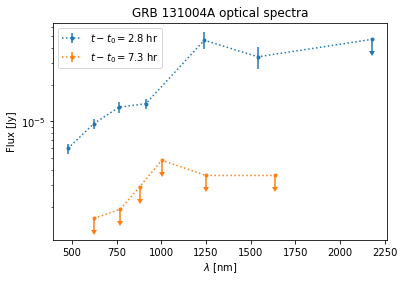

In [51]:
case = "131004A"
for time in [10080,26280]:#[55440,57903,323218]:
    data = results[(results["GRB"]==case) & (results["t_o"]==time)]
    lolims = [np.isinf(f.plus) for f in data["F_o"]]
    pos = [f.value*0.2 if np.isinf(f.plus) else f.plus for f in data["F_o"]]
    uplims = [np.isinf(f.minus) for f in data["F_o"]]
    neg = [f.value*0.2 if np.isinf(f.minus) else f.minus for f in data["F_o"]]
    val = [f.value for f in data["F_o"]]
    lam = 1e9*3e8/data["nu_o"]
    plt.errorbar(lam,val,yerr=(neg,pos),uplims=uplims,marker=".",linestyle=":",capthick=0,label=f"$t-t_0={time/3600:.1f}$ hr")
plt.legend()
plt.yscale("log")
plt.ylabel("Flux [Jy]")
plt.xlabel("$\lambda$ [nm]")
plt.title(f"GRB {case} optical spectra")
plt.savefig(f"./products/{case}_optspec.png",dpi=300,bbox_inches="tight")

## Illustrative example plot

In [ ]:
pd.set_option('display.max_rows', 300)
c1 = [np.abs(B.value-0.5)<0.1 and all(np.isfinite(B.items())) for B in results[B_ox_name]]
c2 = [B.plus != B.minus for B in results["B_x"]]
truths = [c1[i] and c2[i] for i in range(len(results))]
results[truths]

GRB                                                      090426
t_o                                                       590.5
dt%                                                   0.0151538
nu_o                                                7.71532e+14
F_o               4.284500972005573e-05 ± 8.681576700771509e-06
nu_x          4.1880632448032506e+17 (+1.9991731172900093e+1...
F_x             1.2659547203581146e-06 ± 2.9212499565319365e-07
B_ox          0.5592952392772896 (+0.08810721349082486, -0.4...
α                                                          0.94
B_ox_w_err    0.5592952392772896 (+0.08832089110802031, -0.4...
B_x                                         0.96 (+0.16, -0.15)
Jak_dark                                                  False
vdH_dark                                                  False
Year                                                       2009
Name: 2828, dtype: object

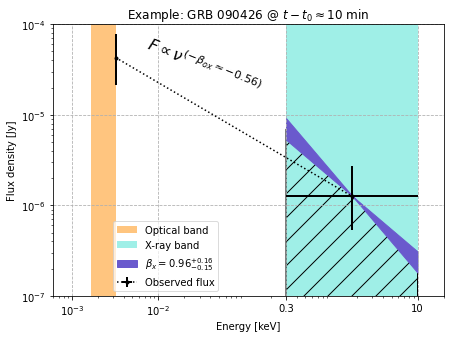

In [79]:
idx = 2828
display(results.loc[idx,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
grb = results.loc[idx,"GRB"]
beta = results.loc[idx,"B_x"]
E_o = results.loc[idx,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[idx,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[idx,"F_o"]
F_x = results.loc[idx,"F_x"]
t_o = results.loc[idx,"t_o"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

fig,ax = plt.subplots(figsize=(7,5))

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x.value],[F_o.value,F_x.value],xerr=[(0,E_x.minus),(0,E_x.plus)],
             yerr=[(F_o.minus*2.5,F_x.minus*2.5),(F_o.plus*4,F_x.plus*5)],
             uplims=~np.isfinite((F_o.minus,F_x.minus)),capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
plt.text(7e-3,1.75e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-%.2f})}$" % results.loc[idx,B_ox_name].value,
         size=16,rotation=-22)

plt.legend(framealpha=0.7, loc="lower left",bbox_to_anchor=(0.14,0))
plt.grid(linestyle="--")
plt.xlim(6e-4,20)
plt.ylim(1e-7,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB {} @ $t-t_0\approx {}$ min".format(grb,round(t_o/60)))
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig(f"./products/{grb}_spectrum.png",bbox_inches="tight",dpi=300)

## To-do

- compare $\beta_x$ distributions between vdH/Jakobsson dark bursts
    - dark between each method
    - dark vs non-dark for each method
- for dark but have optical detections, estimate extinctions ($A_v$)
    - if $\beta_x = \beta_{ox}$ (straight spectrum)
    - if it is -0.5 (assumed dark)
- $N_H$ vs. $\beta_{ox}$ plot and vs. $A_v$
- distribution of $N_H$: are dark mostly at the high end?
- deepest observation of each GRB over time -- have we gotten better at chasing them?
    - some indicator of how early we catch them?
    - at what time are GRBs dark?
- where are my early-time observations from? 
    - check David's tables
    - check Rastinejad, Fong sources
- interpolate XRT light curve to make data matches: does that get us more dark bursts?

### Project status

- finalize 'quantification' of early-time behavior (uninterestingly dark)
    - extra emission in xrays that makes it technically dark but not in the way we care about
- table: total # of sGRBs, # with xray detections, # with optical followup, # with temporally matched (at multiple % values), # dark, # interestingly dark
- fraction is # interestinly dark out of # with optical observations
    - different aspects to this: influence of using big telescopes, getting on it early, progress over the years, etc.
- of the ones that are interestingly dark, what can we say?
- 

### Paper structure
- GRBs two flavors: long/short
- shortly after discovery of afterglow, there were some that were optically dark. even in very fast followup there were some that were not found $\to$ led to classfication scheme for optical darkness where we quantify what we expect to see in optical based on xray. two methods based on what we expect from synchotron spectrum $\to p$. in long GRBs significant fraction due to host galaxy extinction, redshift, extra emission, etc. hasn't been done systematically for sGRBs. that's what we do here
- drill down to these are the interesting ones
- 2 part discussion: darkness in individual GRBs and then darkness in the short GRB population
    - darkness rate, comparison to long GRBs, what makes certain ones dark (characteristics), has rate changed over time
- properties of those and population as a whole in terms of stuff